In [ ]:
#Carga de paquetes

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency

In [ ]:
#Cargamos los datos
pt = pd.read_csv("/content/loan_data_2007_2014.csv")

pt.head()



<ipython-input-3-c0971a0d647f>:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  pt = pd.read_csv("/content/loan_data_2007_2014.csv")


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Exploramos la variable que podria ser nuestra variable objetivo:
#En si contiene el estatus de cada prestamo tmando 10 posibles valores
pt["loan_status"]

pt["loan_status"].value_counts(normalize = True)#Observamos los posibles valores

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

In [ ]:
#Limpieza del conjunto de datos

#Eliminacion de variables con mas del 80% de valores nulos:
pt.dropna(how = 'all', axis = 1, inplace = True)
pt.dropna(thresh = pt.shape[0]*0.2, axis = 1, inplace = True)

#Eliminacion de variables irrelevantes para el modelo:
pt.drop(columns = ['id', 'member_id', 'sub_grade', 'emp_title', 'url', 'desc', 'title',
                          'zip_code', 'next_pymnt_d', 'recoveries', 'collection_recovery_fee',
                          'total_rec_prncp', 'total_rec_late_fee'], inplace = True)




In [ ]:
#Creamos una nueva variable ( columna) basada en los valores relevantes en el estatus del prestamo, esta sera nuestra varaible objetivo.

#Lo que hara la funcion es crear una variable dummy donde los valores asociados a incumplir el prestamo, seran 0 y 1 en caso contrario

pt['good_bad'] = np.where(pt.loc[:, 'loan_status'].isin(['Charged Off', 'Default',
                                                                       'Late (31-120 days)',
                                                                       'Does not meet the credit policy. Status:Charged Off']),
                                 0, 1)

print(pt['good_bad'])

#Eliminamos la variable de estatus de prestamo original
pt.drop(columns = ['loan_status'], inplace = True)



0         1
1         0
2         1
3         1
4         1
         ..
466280    1
466281    0
466282    1
466283    1
466284    1
Name: good_bad, Length: 466285, dtype: int64


In [ ]:
# Division de datos de prueba y entrenamiento:

X = pt.drop('good_bad', axis = 1) #Caracteristicas
y = pt['good_bad'] #Etiquetas

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 42, stratify = y)#Como esta desequilibrada la muestra estratificamos para balancearla.

X_train, X_test = X_train.copy(), X_test.copy()#Para evitar advertencias más adelante.


In [ ]:
#Continuamos con la limpieza de los datos:

pt["emp_length"]

#Creamos una funcion que corrija la variable "emp_length"(años trabajando), tanto su formato como valores cero
def emp_length_converter(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)


#Creamos una funcion para modificar el formato las valiables de fechas(date) y creamos una nueva variable con la diferencia de tiempo entre el dia de hoy y la fecha del prestamo.
def date_columns(df, column):
    today_date = pd.to_datetime('2023-07-25')
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) /
							np.timedelta64(1, 'M')))
    df['mths_since_' + column] = df['mths_since_' + column].apply(
		lambda x: df['mths_since_' + column].max() if x < 0 else x)
    df.drop(columns = [column], inplace = True)



#Creamos una funcion para eleminar el texto y convertir en numerica la variable "term" que es lumero de pagos(plazos) del prestamo
def loan_term_converter(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))



#Aplicamos nuestras funciones al conjunto de entrenamiento
date_columns(X_train, 'earliest_cr_line') #El mes en que se abrió la primera línea de crédito informada del prestatario
date_columns(X_train, 'issue_d') #El mes en que se financió el préstamo..
date_columns(X_train, 'last_pymnt_d') #Se recibió el pago del último mes
date_columns(X_train, 'last_credit_pull_d') #El mes más reciente, LC sacó crédito para este préstamo
emp_length_converter(X_train, 'emp_length')
loan_term_converter(X_train, 'term')

<ipython-input-8-e5d4506d0951>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('\+ years', '')


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [25] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,grade,home_ownership,verification_status,purpose
456615,A,MORTGAGE,Source Verified,credit_card
451541,D,OWN,Verified,other
394474,D,OWN,Source Verified,credit_card
110294,A,MORTGAGE,Not Verified,debt_consolidation
139343,B,MORTGAGE,Verified,debt_consolidation
...,...,...,...,...
163633,C,MORTGAGE,Verified,debt_consolidation
399306,B,MORTGAGE,Verified,credit_card
57787,C,MORTGAGE,Verified,debt_consolidation
81641,C,MORTGAGE,Not Verified,debt_consolidation


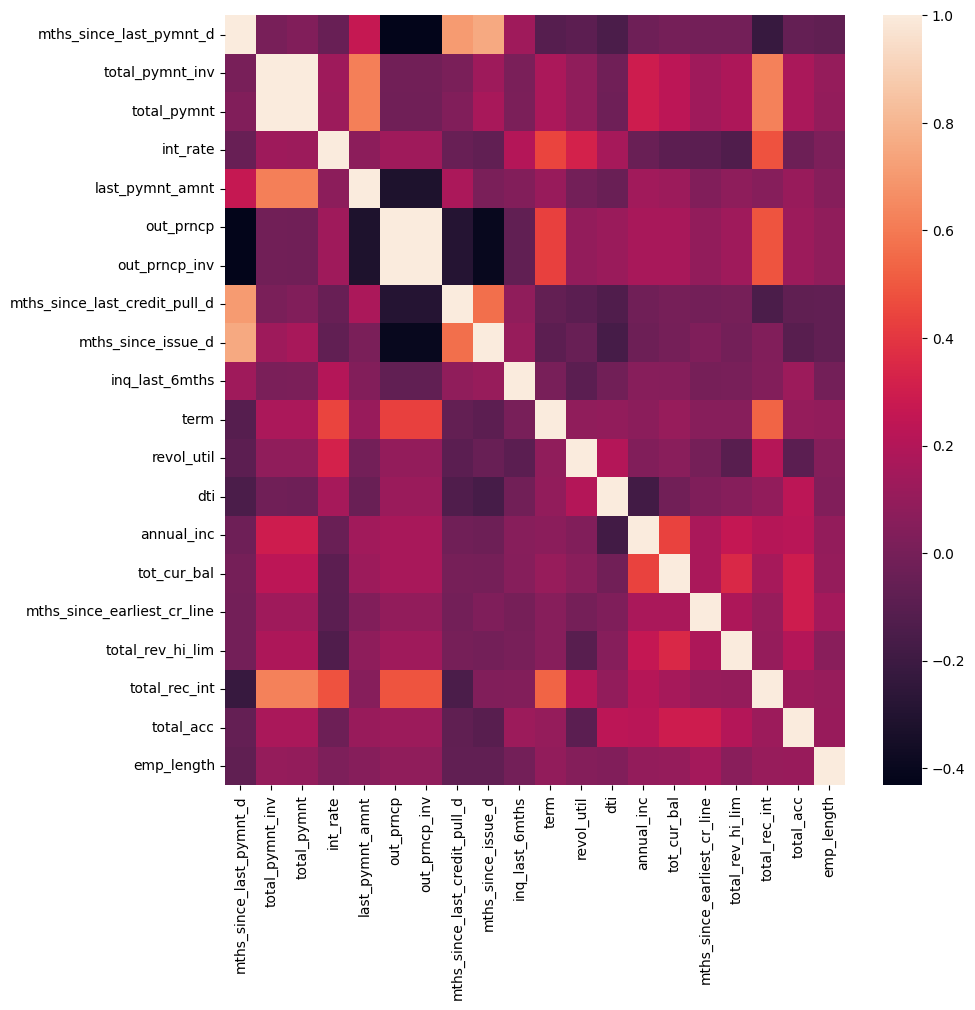

In [ ]:
#Se seleccionan las caractaristicas mas adecuadas para nuestro variable(binaria) objetivo:
#Para hacer esta selección se realizan las pruebas Chi-cuadrada para caracteristicas categoricas y el estadistico F de ANOVA para caracteristicas numericas.
#Ambas pruebas sirven para verificar el grado de asociacion entre las variables(osea nos da que tan explicativas y por lo tanto útiles pueden ser las variables).

# Dividimos el conjunto de entrenamiento en variables categoricas y numericas:
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

# Creamos un diccionario para guardar los resutados de la prueba Chi-cuadrada:

prue_chi2 = {}

#Ciclo para recorrer cada columna del conjunto de entrenamiento y calcular su chi-cuadrada:

for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    prue_chi2.setdefault('Feature',[]).append(column)
    prue_chi2.setdefault('p-value',[]).append(round(p, 10))


#Convertimos el diccionario en un dataframe y lo ordenamos deacurdo al valor de cada resultado:
chi2_result = pd.DataFrame(data = prue_chi2)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)#Se conservaran las 4 mejores variables.



#Para poder usar la funcion f_classif tenemos que remplazar los datos faltante:
X_train_num.fillna(X_train_num.mean(), inplace = True)#Se remplazara con los valores promedio.


#Ahora calculamos los estadisticos F y sus valores p:

F_estadistico , p_values = f_classif(X_train_num, y_train)#Se aplica esta función para evaluar la relación entre cada característica (columna) del conjunto de datos y la variable objetivo (la clase o etiqueta a predecir) en un problema de clasificación.
#Características con valores p pequeños (generalmente, por debajo de un umbral de significancia) se consideran más relevantes para la clasificación y pueden ser seleccionadas para construir un modelo.


# Convertimos los resultados enn un data frame y los ordenamos:
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values,
					'F-Score': F_estadistico, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)

#Aqui nos quedaremos con las 20 caracteristicas principales:

top_car_num = ANOVA_F_table.iloc[:20,0].to_list()


#Ahora con estas caracteristicas buscamos posible multicolinialdad (osea que esten muy relacionadas entre si determinadas variables explicativas) ,esto puede afectar la interpretacion de los resultados del modelo, no asi las predicciones.
#Para lo que calculamos niveles de correlacion entre las variables a pares.
corrmat = X_train_num[top_car_num].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat)
#Observamos que las características "total_pymnt_inv" y "out_prncp_inv" muestran altos niveles(cuadros mas claros) de correlacion con otras características.
#Por lo tanto eliminaremos estas caracteristicas.



#Now creamos una lista con todas las caracteristicas que eliminaremos:

drop_columns_list = ANOVA_F_table.iloc[20:, 0].to_list()#Primeras 20 del estadistico F
drop_columns_list.extend(chi2_result.iloc[4:, 0].to_list())#Primeras 4 del la prueba chi2.
drop_columns_list.extend(['out_prncp_inv', 'total_pymnt_inv'])#Caracteristicas detectadas que podrian causar multicolinialidad.

drop_columns_list#Lista final



#Creamos una función para eliminar las variables en la lista:
def car_to_drop(df, columns_list):
    df.drop(columns = columns_list, inplace = True)

car_to_drop(X_train, drop_columns_list)#Aplicamos la función.



X_train[chi2_result.iloc[0:4,0]]#Quedan 22 variables en total, en el conjunto de entrenamiento





In [ ]:
#Crearemos variables dummies (binarias) para nuestras 4 varaibles (carecteristicas) categoricas del conjunto de entrenamiento:

#Definimos una funcion para crear las variables dummies y que se genere un data frame integrado por las variables creadas:
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':')) #La funcion apilicada aquí crea columnas (variables dummies) adicionales por cada categoria con valores de 0 y 1 .
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)#Aqui concatenamos el dataframe de las variables dummies con el conjunto de entreneminto.
    return df

# Aplicamos la función:
X_train = dummy_creation(X_train, ['grade', 'home_ownership', 'verification_status', 'purpose'])


In [ ]:
#Ahora actualizaremos el conjunto de datos de prueba aplicandole todo lo que hicimos con el conjunto de datos de entrenamiento (debe de haber coherencia entre los dos conjuntos):
emp_length_converter(X_test, 'emp_length')
date_columns(X_test, 'earliest_cr_line')
date_columns(X_test, 'issue_d')
date_columns(X_test, 'last_pymnt_d')
date_columns(X_test, 'last_credit_pull_d')
loan_term_converter(X_test, 'term')
car_to_drop(X_test, drop_columns_list)
X_test = dummy_creation(X_test, ['grade', 'home_ownership', 'verification_status', 'purpose'])


#Un paso importante es reindexar las variables dummies para asegurarnos que todas las columnas(variables) de característcas en el conjunto de entrenamiento tambien estén disponibles en el conjunto de prueba y el modelo pueda trabajar bien.
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

<ipython-input-8-e5d4506d0951>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('\+ years', '')


In [ ]:
X_test

,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,inq_last_6mths,...,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding
395346,36,14.64,C,10.0,OWN,50000.0,Source Verified,home_improvement,19.11,4.0,...,1,0,0,0,0,0,0,0,0,0
376583,36,7.12,A,1.0,RENT,63000.0,Not Verified,debt_consolidation,7.98,0.0,...,0,0,0,0,0,0,0,0,0,0
297790,36,14.99,C,0.0,RENT,82000.0,Source Verified,debt_consolidation,23.35,2.0,...,0,0,0,0,0,0,0,0,0,0
47347,36,9.67,B,2.0,RENT,60000.0,Verified,debt_consolidation,28.34,1.0,...,0,0,0,0,0,0,0,0,0,0
446772,60,18.25,D,10.0,MORTGAGE,86000.0,Source Verified,debt_consolidation,31.02,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32147,36,6.39,A,10.0,OWN,33600.0,Not Verified,medical,3.39,1.0,...,0,0,0,1,0,0,0,0,0,0
78936,36,19.52,D,6.0,RENT,42000.0,Not Verified,debt_consolidation,21.71,1.0,...,0,0,0,0,0,0,0,0,0,0
459582,36,23.40,E,8.0,MORTGAGE,30000.0,Not Verified,other,17.48,0.0,...,0,0,0,0,0,1,0,0,0,0
454915,60,15.61,C,5.0,MORTGAGE,80000.0,Verified,debt_consolidation,20.60,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Now usaremos las Tecnicas WoE (Weight of Evidence) Binning  y IV (Valor de la información).

#La primera sirve para medir el nivel de relación entre las categorias de una variable discreta y la variable objetivo.
##Se usa esta tecnica para capturar de manera más clara y precisa como las variables discretas influyen en la varaible objetivo a traves de asignarles un valor a cada categoria(bins) de la varaible discreta.
##Una parte fundamental de esta tecnica es hacer discretas las variables continuas(se crean rangos), esto nos para capturar de manera más significativa los efectos de la variable continua sobre la variable objetivo y nos sirve para hacer interpretaciones más simples.

#La segunda tecnica usa el valor WoE calculado en la primera y simplen nos da una medida de importancia de las caracteristicas(variables explicativas), en pocas palabras us poder explicativo con respecto a la función objetivo.




#Primero creamos copias de los conjuntos de entrenamiento y prueba para ser preprocesados usando WoE.

X_train_prepr = X_train.copy()
y_train_prepr = y_train.copy()
X_test_prepr = X_test.copy()
y_test_prepr = y_test.copy()



#Ahora creamos la función para calcular y guardar los valores WoE y IV de las variables discretas:
##La función toma 3 argumentos, el conjunto de entrenamiento con las caracteristicas, un string(con el nombre de la columna(Caracteristica)) y el conjunto de entrenamiento con las etiquetas de clase.



def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']#Calcula el numero de observaciones "buenas" osea donde se pago.
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']##Calcula el numero de observaciones "malas" osea donde no se pago.
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])#Se calcula el valor WoE.
    df = df.sort_values(['WoE'])#Ordenar los valores segun el WoE.
    df = df.reset_index(drop = True)#Reestablecer indices
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']#Se calcual el IV para cada bin.
    df['IV'] = df['IV'].sum()#Se calcual el IV para cada bin.
    return df



In [ ]:
#Creamos una función para graficar los resultados del WoE.
sns.set()#Estilo de graficos
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)


In [ ]:
#Aplicamos la funcion para la variable discreta "Grade"
df_temp = woe_discrete(X_train_prepr, 'grade', y_train_prepr)
df_temp#Vemos que las personas con grado G tienen un impacto negativo en el aumento de la probabilidad de cumplimiemto(pagar).
        #  y que las personas con grado A tienen un impacto positivo.

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,2623,0.721693,0.007032,1893.0,730.0,0.005697,0.017904,-1.144981,NaN,NaN,0.292145
1,F,10606,0.758061,0.028432,8040.0,2566.0,0.024198,0.062932,-0.955774,0.036369,0.189207,0.292145
2,E,28590,0.804477,0.076643,23000.0,5590.0,0.069224,0.137097,-0.683340,0.046416,0.272434,0.292145
3,D,61713,0.845527,0.165438,52180.0,9533.0,0.157049,0.233801,-0.397915,0.041050,0.285425,0.292145
4,C,100342,0.885870,0.268993,88890.0,11452.0,0.267536,0.280865,-0.048620,0.040343,0.349295,0.292145
5,B,109344,0.921422,0.293125,100752.0,8592.0,0.303238,0.210723,0.363975,0.035552,0.412595,0.292145
6,A,59810,0.961361,0.160336,57499.0,2311.0,0.173057,0.056678,1.116232,0.039939,0.752257,0.292145


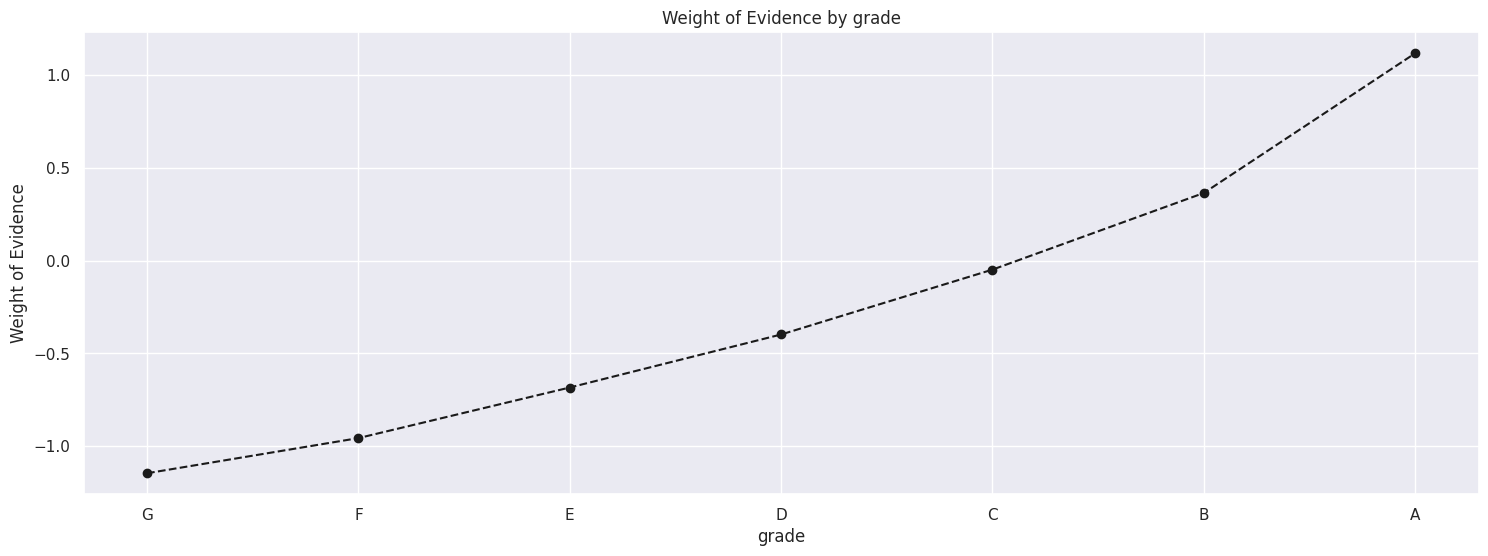

In [ ]:
#Graficamos:

plot_by_woe(df_temp)

#Aqui se observa como van cambiando los efectos explicativos de los diferentes bins de las variables explicativas, sobre la variable objetivo.
#Dado que hay un aumento continuo(monotono), no se aprecia que exista la necesidad de combinar los bins(categorias/rangos).


In [ ]:
#haremos lo anterior para cada variable discreta(4 en total):
#Esto es para revisar que los valores WoE y IV tenga sentido, y ver si es pertenente combinar algun bin.

#Home_Ownership
df_temp = woe_discrete(X_train_prepr, 'home_ownership', y_train_prepr)
df_temp


,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,OTHER,159,0.792453,0.000426,126.0,33.0,0.000379,0.000809,-0.758081,NaN,NaN,0.02166
1,NONE,41,0.853659,0.000110,35.0,6.0,0.000105,0.000147,-0.334267,0.061206,0.423814,0.02166
2,RENT,150776,0.874052,0.404195,131786.0,18990.0,0.396642,0.465738,-0.160588,0.020393,0.173678,0.02166
3,OWN,33313,0.890343,0.089304,29660.0,3653.0,0.089269,0.089591,-0.003605,0.016292,0.156984,0.02166
4,MORTGAGE,188739,0.904143,0.505965,170647.0,18092.0,0.513604,0.443714,0.146272,0.013800,0.149877,0.02166


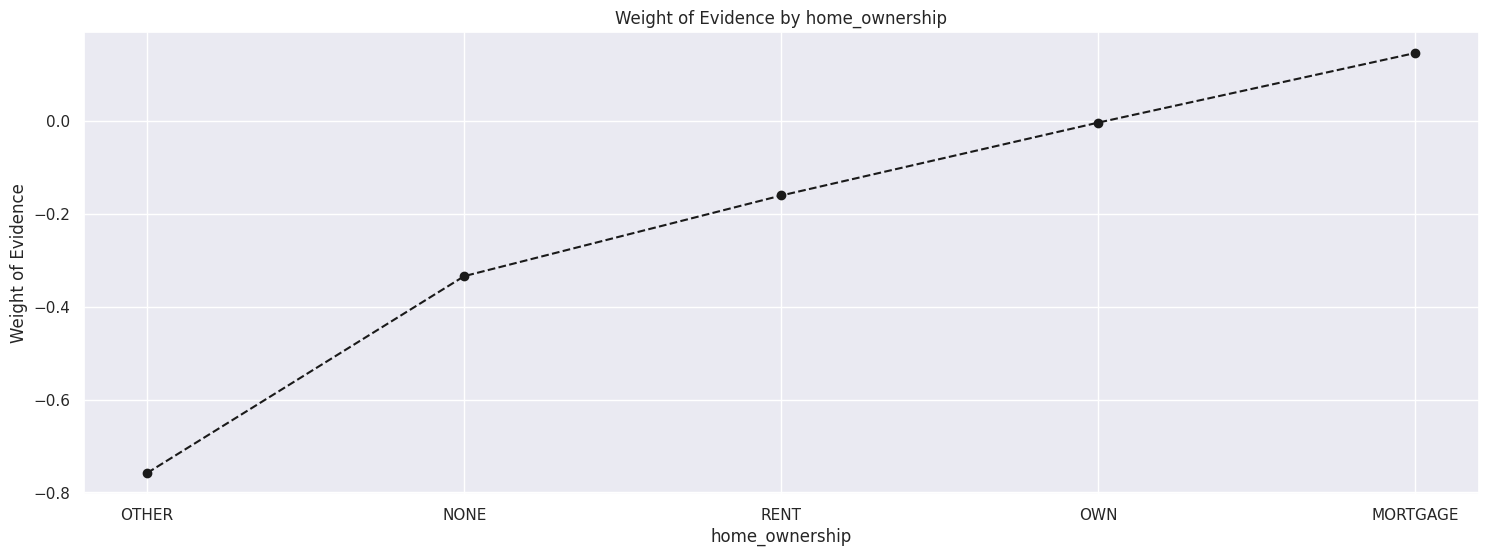

In [ ]:
plot_by_woe(df_temp)

In [ ]:
#Verification_status:

df_temp = woe_discrete(X_train_prepr, 'verification_status', y_train_prepr)
df_temp

,verification_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Verified,134571,0.872045,0.360753,117352.0,17219.0,0.353200,0.422303,-0.178691,NaN,NaN,0.022522
1,Source Verified,119969,0.895723,0.321609,107459.0,12510.0,0.323424,0.306813,0.052726,0.023678,0.231417,0.022522
2,Not Verified,118488,0.906784,0.317638,107443.0,11045.0,0.323376,0.270883,0.177128,0.011061,0.124402,0.022522


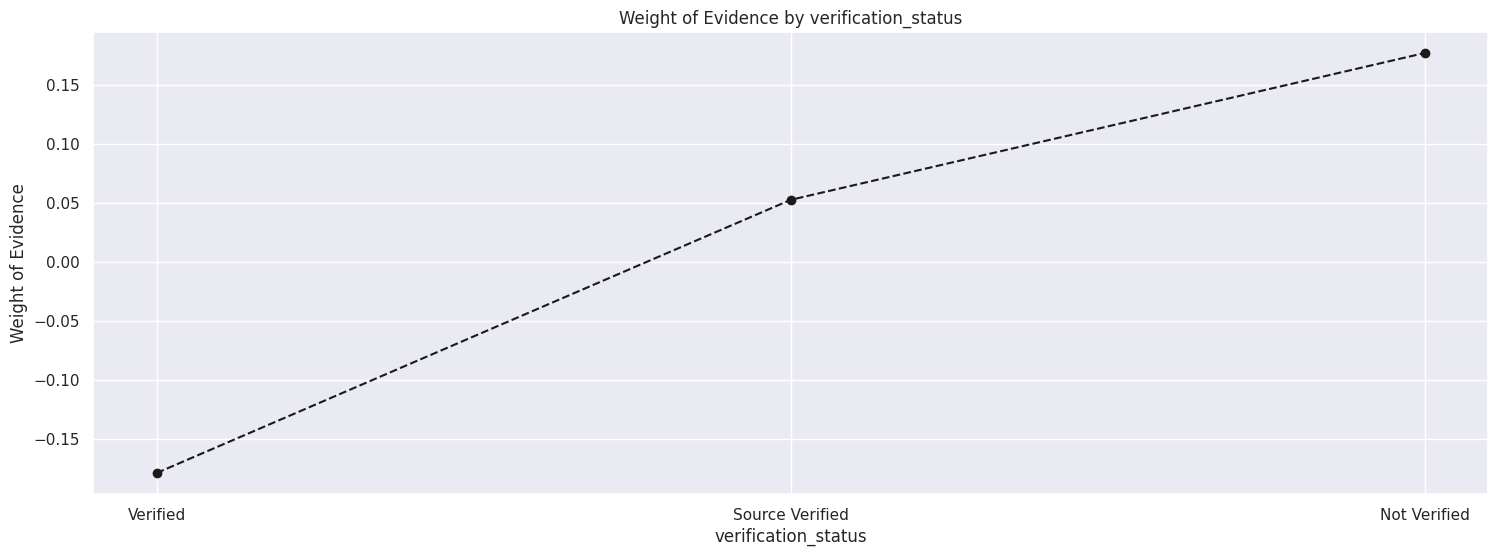

In [ ]:
plot_by_woe(df_temp)

In [ ]:
#Purpose:
df_temp = woe_discrete(X_train_prepr, 'purpose', y_train_prepr)
df_temp

,purpose,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,small_business,5605,0.787333,0.015026,4413.0,1192.0,0.013282,0.029234,-0.788933,NaN,NaN,0.036668
1,educational,351,0.792023,0.000941,278.0,73.0,0.000837,0.001790,-0.760693,0.004690,0.028240,0.036668
2,renewable_energy,295,0.837288,0.000791,247.0,48.0,0.000743,0.001177,-0.459668,0.045265,0.301026,0.036668
3,moving,2397,0.848561,0.006426,2034.0,363.0,0.006122,0.008903,-0.374498,0.011273,0.085169,0.036668
4,house,1824,0.861294,0.004890,1571.0,253.0,0.004728,0.006205,-0.271777,0.012733,0.102721,0.036668
5,other,19006,0.861675,0.050951,16377.0,2629.0,0.049291,0.064477,-0.268581,0.000381,0.003196,0.036668
6,medical,3750,0.863467,0.010053,3238.0,512.0,0.009746,0.012557,-0.253469,0.001791,0.015112,0.036668
7,vacation,2003,0.875686,0.005370,1754.0,249.0,0.005279,0.006107,-0.145654,0.012220,0.107815,0.036668
8,wedding,1900,0.881053,0.005093,1674.0,226.0,0.005038,0.005543,-0.095419,0.005366,0.050235,0.036668
9,debt_consolidation,219196,0.886704,0.587613,194362.0,24834.0,0.584980,0.609065,-0.040346,0.005652,0.055072,0.036668


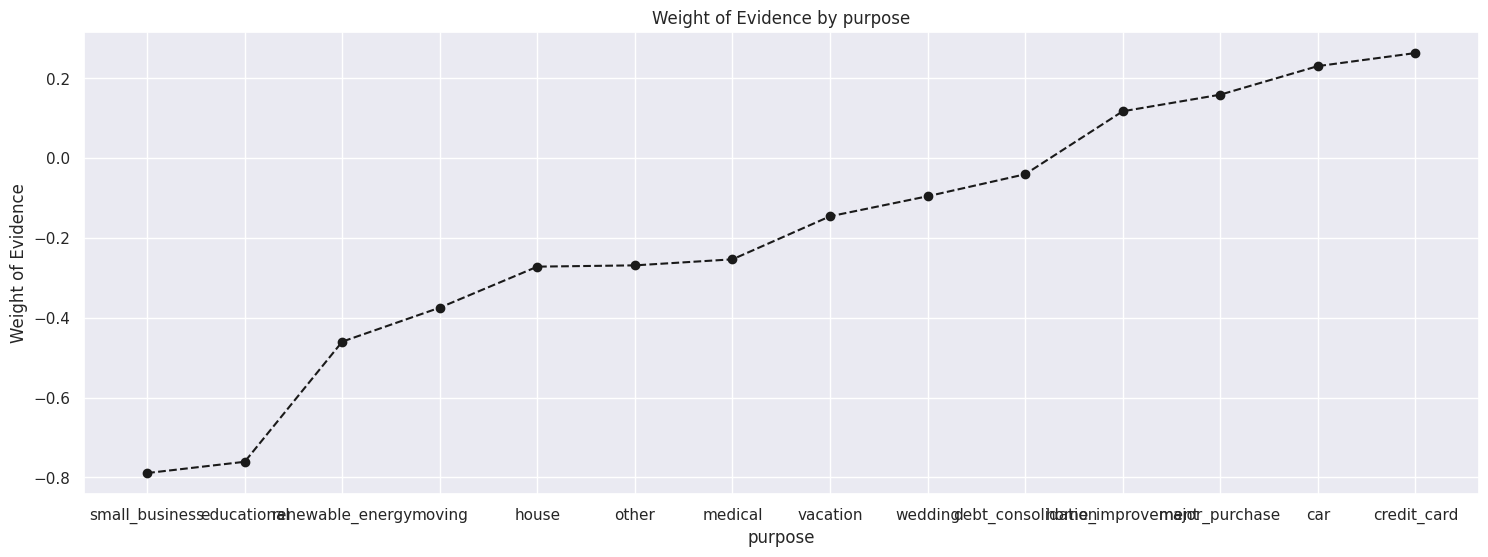

In [ ]:
plot_by_woe(df_temp)#Dada la similitud en el impacto de algunos bin podriamos combinar bins.

In [ ]:
#Hacer lo anterior pero ahora a las variables(caracteristicas) continuas:

len(top_car_num)#Muestra cuales son nuestras variables continuas excepto por 'total_pymnt_inv' y 'out_prncp_inv'] que las eliminamos previamente.

#Definemos la función del WoE y Iv para variables (carácteristicas) continuas:
def woe_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']#Calcula el numero de observaciones "buenas" osea donde se pago.
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']##Calcula el numero de observaciones "malas" osea donde no se pago.
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])#Se calcula el valor WoE.
    #df = df.sort_values(['WoE'])#Ordenar los valores segun el WoE.
    #df = df.reset_index(drop = True)#Reestablecer indices
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']#Se calcual el IV para cada bin.
    df['IV'] = df['IV'].sum()#Se calcual el IV para cada bin.
    return df



In [ ]:
# Carácteristica "term"

df_temp = wo_continuous(X_train_prepr, 'term', y_train_prepr)
df_temp

,term,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,36,270199,0.903238,0.72434,244054.0,26145.0,0.73454,0.641217,0.135876,NaN,NaN,0.040794
1,60,102829,0.857735,0.27566,88200.0,14629.0,0.26546,0.358783,-0.301254,0.045503,0.43713,0.040794


In [ ]:

#int_rate_factor

#Aquí dado que tenemso muchas valores unicos en la caracteristicas, creamos bins(50)
X_train_prepr['int_rate_factor'] = pd.cut(X_train_prepr['int_rate'], 50)

#Aplicamos la función
df_temp = woe_continuous(X_train_prepr, 'int_rate_factor', y_train_prepr)
df_temp

,int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(5.399, 5.833]",776,0.962629,0.002080,747.0,29.0,0.002248,0.000711,1.150914,NaN,NaN,0.346603
1,"(5.833, 6.246]",8408,0.979305,0.022540,8234.0,174.0,0.024782,0.004267,1.759117,0.016677,0.608203,0.346603
2,"(6.246, 6.658]",7842,0.971181,0.021023,7616.0,226.0,0.022922,0.005543,1.419616,0.008125,0.339500,0.346603
3,"(6.658, 7.071]",1777,0.969612,0.004764,1723.0,54.0,0.005186,0.001324,1.364983,0.001569,0.054633,0.346603
4,"(7.071, 7.484]",3186,0.976146,0.008541,3110.0,76.0,0.009360,0.001864,1.613790,0.006534,0.248806,0.346603
5,"(7.484, 7.897]",12590,0.963781,0.033751,12134.0,456.0,0.036520,0.011184,1.183419,0.012365,0.430371,0.346603
6,"(7.897, 8.31]",9680,0.949483,0.025950,9191.0,489.0,0.027663,0.011993,0.835762,0.014297,0.347656,0.346603
7,"(8.31, 8.722]",6666,0.965047,0.017870,6433.0,233.0,0.019362,0.005714,1.220303,0.015563,0.384540,0.346603
8,"(8.722, 9.135]",9578,0.938923,0.025676,8993.0,585.0,0.027067,0.014347,0.634735,0.026124,0.585568,0.346603
9,"(9.135, 9.548]",6563,0.965565,0.017594,6337.0,226.0,0.019073,0.005543,1.235771,0.026642,0.601036,0.346603


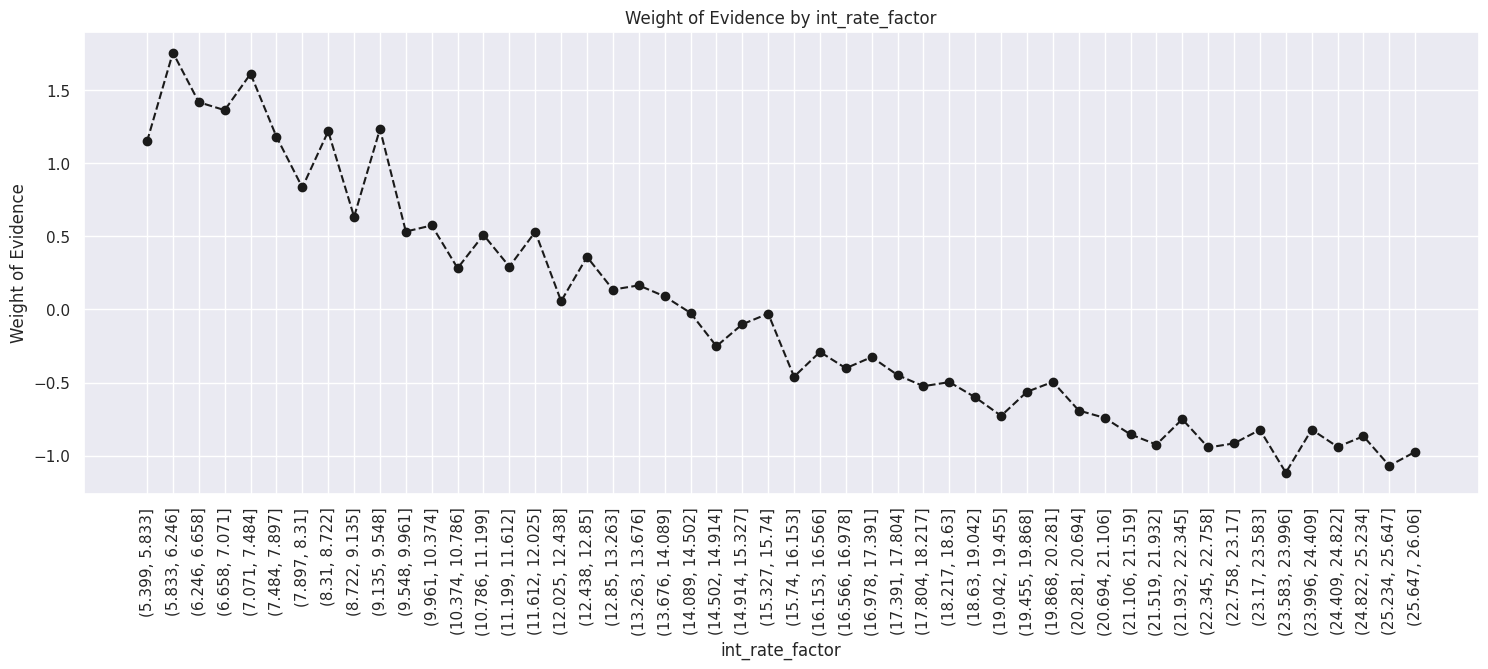

In [ ]:
plot_by_woe(df_temp, 90)#Despues de los resultados decidimos no usar esta carácteristica por que sus valores IV son muy bajos y los valores WoE se mueven en rangos muy bajos lo que significa baj poder para diferenciar buenos y malos prestamos.

In [ ]:
#annual_inc_factor
#Creamos bins(fine-classing):
X_train_prepr['annual_inc_factor'] = pd.cut(X_train_prepr['annual_inc'], 50)

#Aplicamos las funciones:
df_temp = woe_continuous(X_train_prepr, 'annual_inc_factor', y_train_prepr)
df_temp



#Debido a que se observa que existen outliers, ya que que muy pocas personas ganan mas de 7300000 y la mayoria ganan menos de 151,000, crearemos una nueva categoria para las agrupar a las personas que ganen mas de 150,000
X_train_prepr_temp = X_train_prepr[X_train_prepr['annual_inc'] <= 150000].copy()

# Creamos bins otra vez:
X_train_prepr_temp['annual_inc_factor'] = pd.cut(X_train_prepr_temp['annual_inc'], 50)

#Aplicamos la función otra vez:
df_temp = woe_continuous(X_train_prepr_temp, 'annual_inc_factor', y_train_prepr[X_train_prepr_temp.index])# Aseguremonos de seleccionar los indices relevantes de la columna(osea que concuerde la columna de etiquetas con la de entrenamiento).
df_temp

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(1747.896, 4858.08]",16,0.812500,0.000045,13.0,3.0,0.000041,0.000076,-0.614889,NaN,NaN,0.04906
1,"(4858.08, 7820.16]",45,0.822222,0.000126,37.0,8.0,0.000117,0.000202,-0.549749,0.009722,0.065139,0.04906
2,"(7820.16, 10782.24]",342,0.847953,0.000959,290.0,52.0,0.000915,0.001315,-0.362589,0.025731,0.187161,0.04906
3,"(10782.24, 13744.32]",696,0.824713,0.001952,574.0,122.0,0.001811,0.003085,-0.532617,0.023241,0.170029,0.04906
4,"(13744.32, 16706.4]",1392,0.847701,0.003905,1180.0,212.0,0.003723,0.005361,-0.364542,0.022989,0.168075,0.04906
5,"(16706.4, 19668.48]",1908,0.849057,0.005352,1620.0,288.0,0.005111,0.007282,-0.354005,0.001355,0.010538,0.04906
6,"(19668.48, 22630.56]",3592,0.843820,0.010076,3031.0,561.0,0.009563,0.014185,-0.394299,0.005237,0.040294,0.04906
7,"(22630.56, 25592.64]",6450,0.859380,0.018093,5543.0,907.0,0.017489,0.022934,-0.271077,0.015560,0.123222,0.04906
8,"(25592.64, 28554.72]",5729,0.848316,0.016070,4860.0,869.0,0.015334,0.021973,-0.359775,0.011064,0.088698,0.04906
9,"(28554.72, 31516.8]",10353,0.858881,0.029041,8892.0,1461.0,0.028055,0.036942,-0.275195,0.010566,0.084580,0.04906


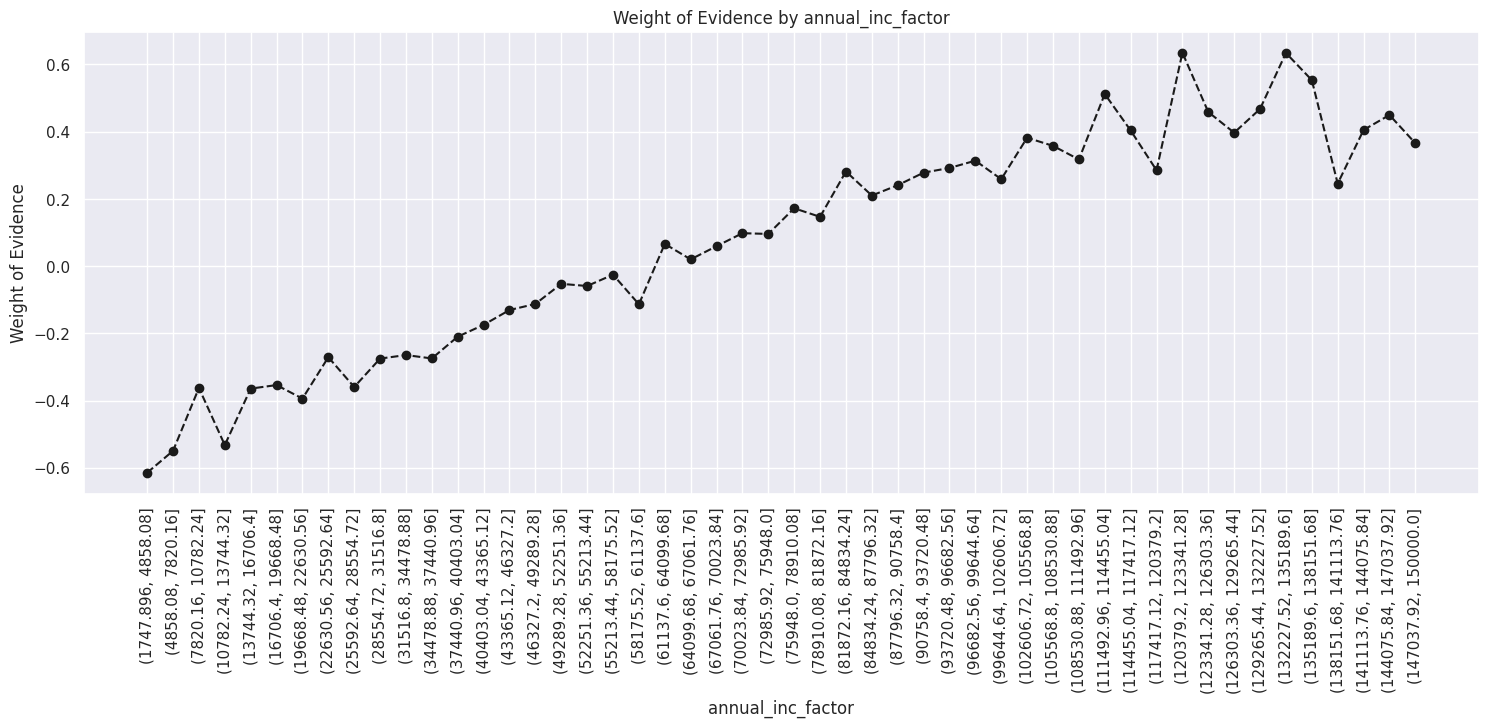

In [ ]:
plot_by_woe(df_temp, 90)#Dada la simiitud en los valores seria conveniente combinar bins.

In [ ]:
#Se hace los mismo para
#"dti_factor","inq_last_6mths","out_prncp"

#En la carácteristica 'revol_util'  muchos valores por encima de 1 lo cual es raro por lo que filtramos:

X_train_prepr[X_train_prepr["revol_util"]>1]
X_train_prepr_temp = X_train_prepr[X_train_prepr['revol_util'] <= 1].copy()

#Se repiten los pasos:
X_train_prepr_temp['revol_util_factor'] = pd.cut(X_train_prepr_temp['revol_util'], 10)
df_temp = woe_continuous(X_train_prepr_temp, 'revol_util_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp


,revol_util_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.001, 0.1]",1957,0.866633,0.656271,1696.0,261.0,0.643643,0.752161,-0.155806,NaN,NaN,0.090671
1,"(0.1, 0.2]",153,0.882353,0.051308,135.0,18.0,0.051233,0.051873,-0.012411,0.015720,0.143396,0.090671
2,"(0.2, 0.3]",136,0.941176,0.045607,128.0,8.0,0.048577,0.023055,0.745275,0.058824,0.757686,0.090671
3,"(0.3, 0.4]",111,0.882883,0.037223,98.0,13.0,0.037192,0.037464,-0.007296,0.058294,0.752571,0.090671
4,"(0.4, 0.5]",110,0.909091,0.036888,100.0,10.0,0.037951,0.028818,0.275271,0.026208,0.282567,0.090671
5,"(0.5, 0.6]",94,0.946809,0.031522,89.0,5.0,0.033776,0.014409,0.851885,0.037718,0.576613,0.090671
6,"(0.6, 0.7]",117,0.905983,0.039235,106.0,11.0,0.040228,0.031700,0.238230,0.040826,0.613655,0.090671
7,"(0.7, 0.8]",111,0.927928,0.037223,103.0,8.0,0.039089,0.023055,0.527974,0.021945,0.289744,0.090671
8,"(0.8, 0.9]",87,0.908046,0.029175,79.0,8.0,0.029981,0.023055,0.262693,0.019882,0.265281,0.090671
9,"(0.9, 1.0]",106,0.952830,0.035547,101.0,5.0,0.038330,0.014409,0.978369,0.044784,0.715676,0.090671


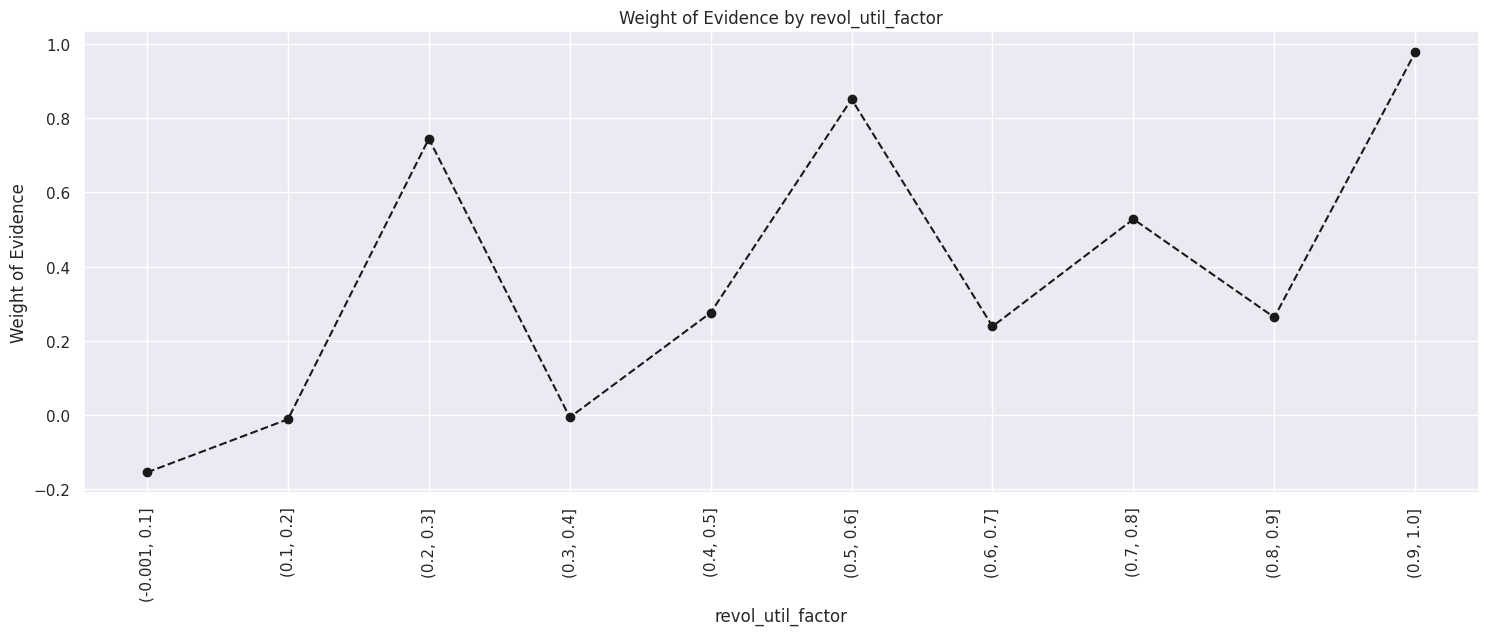

In [ ]:
plot_by_woe(df_temp, 90)

In [ ]:
#total_acc
#Tambien se persiven valores raros y se filtra:
X_train_prepr_temp = X_train_prepr[X_train_prepr['total_acc'] <= 50].copy()
X_train_prepr_temp['total_acc_factor'] = pd.cut(X_train_prepr_temp['total_acc'], 20)
df_temp = woe_continuous(X_train_prepr_temp, 'total_acc_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp

,total_acc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(0.951, 3.45]",462,0.800866,0.001278,370.0,92.0,0.001149,0.002320,-0.702454,NaN,NaN,0.008031
1,"(3.45, 5.9]",3117,0.861084,0.008621,2684.0,433.0,0.008338,0.010921,-0.269843,6.021858e-02,0.432611,0.008031
2,"(5.9, 8.35]",11689,0.870990,0.032330,10181.0,1508.0,0.031627,0.038033,-0.184430,9.905443e-03,0.085413,0.008031
3,"(8.35, 10.8]",13426,0.876434,0.037134,11767.0,1659.0,0.036554,0.041841,-0.135085,5.443966e-03,0.049345,0.008031
4,"(10.8, 13.25]",28228,0.880402,0.078074,24852.0,3376.0,0.077203,0.085145,-0.097922,3.968652e-03,0.037163,0.008031
5,"(13.25, 15.7]",23108,0.882465,0.063913,20392.0,2716.0,0.063348,0.068499,-0.078186,2.062510e-03,0.019736,0.008031
6,"(15.7, 18.15]",38785,0.886683,0.107272,34390.0,4395.0,0.106832,0.110845,-0.036870,4.218049e-03,0.041316,0.008031
7,"(18.15, 20.6]",27039,0.886682,0.074785,23975.0,3064.0,0.074478,0.077276,-0.036878,7.962181e-07,0.000008,0.008031
8,"(20.6, 23.05]",40701,0.891673,0.112572,36292.0,4409.0,0.112741,0.111198,0.013781,4.991223e-03,0.050659,0.008031
9,"(23.05, 25.5]",25768,0.890407,0.071270,22944.0,2824.0,0.071275,0.071223,0.000734,1.266717e-03,0.013047,0.008031


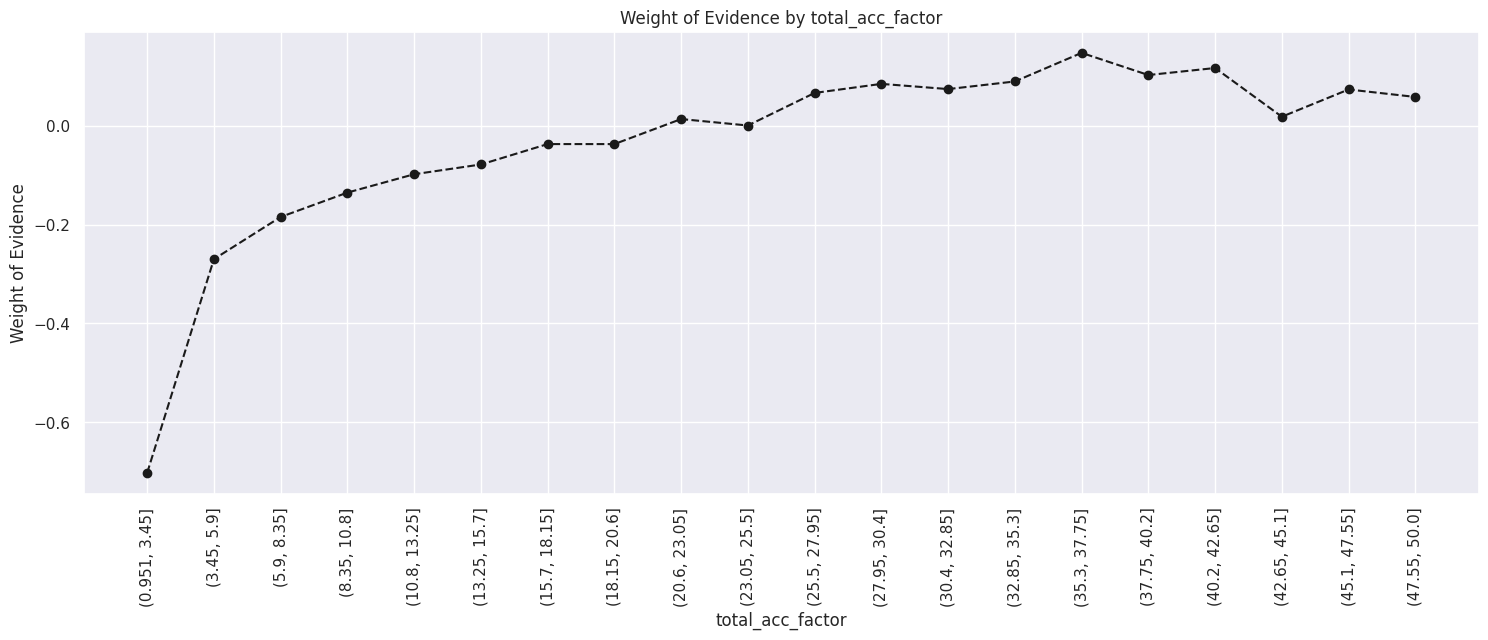

In [ ]:
plot_by_woe(df_temp, 90)#Dada sus bajos IV se descarta esta variable.

In [ ]:
#"out_prncp"

X_train_prepr['out_prncp_factor'] = pd.cut(X_train_prepr['out_prncp'], 25)#Aquí se crean 25 bins.


df_temp = woe_continuous(X_train_prepr, 'out_prncp_factor', y_train_prepr)
df_temp
#Se observan valores IV muy altos(>0.5) lo cual es sospechoso pero esta vez dejaremos la carácteristica.


,out_prncp_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-32.16, 1286.415]",196686,0.823078,0.527269,161888.0,34798.0,0.487242,0.853436,-0.560510,NaN,NaN,0.681688
1,"(1286.415, 2572.83]",19695,0.977558,0.052798,19253.0,442.0,0.057947,0.010840,1.676257,0.154479,2.236767,0.681688
2,"(2572.83, 3859.246]",21412,0.971511,0.057401,20802.0,610.0,0.062609,0.014961,1.431490,0.006046,0.244767,0.681688
3,"(3859.246, 5145.661]",17867,0.969217,0.047897,17317.0,550.0,0.052120,0.013489,1.351671,0.002294,0.079820,0.681688
4,"(5145.661, 6432.076]",14835,0.964341,0.039769,14306.0,529.0,0.043057,0.012974,1.199591,0.004876,0.152080,0.681688
5,"(6432.076, 7718.491]",13042,0.965649,0.034963,12594.0,448.0,0.037905,0.010987,1.238327,0.001308,0.038737,0.681688
6,"(7718.491, 9004.906]",13099,0.967860,0.035115,12678.0,421.0,0.038158,0.010325,1.307136,0.002211,0.068808,0.681688
7,"(9004.906, 10291.322]",12866,0.967744,0.034491,12451.0,415.0,0.037474,0.010178,1.303423,0.000116,0.003713,0.681688
8,"(10291.322, 11577.737]",9890,0.960061,0.026513,9495.0,395.0,0.028578,0.009688,1.081780,0.007684,0.221643,0.681688
9,"(11577.737, 12864.152]",9513,0.964785,0.025502,9178.0,335.0,0.027623,0.008216,1.212579,0.004724,0.130799,0.681688


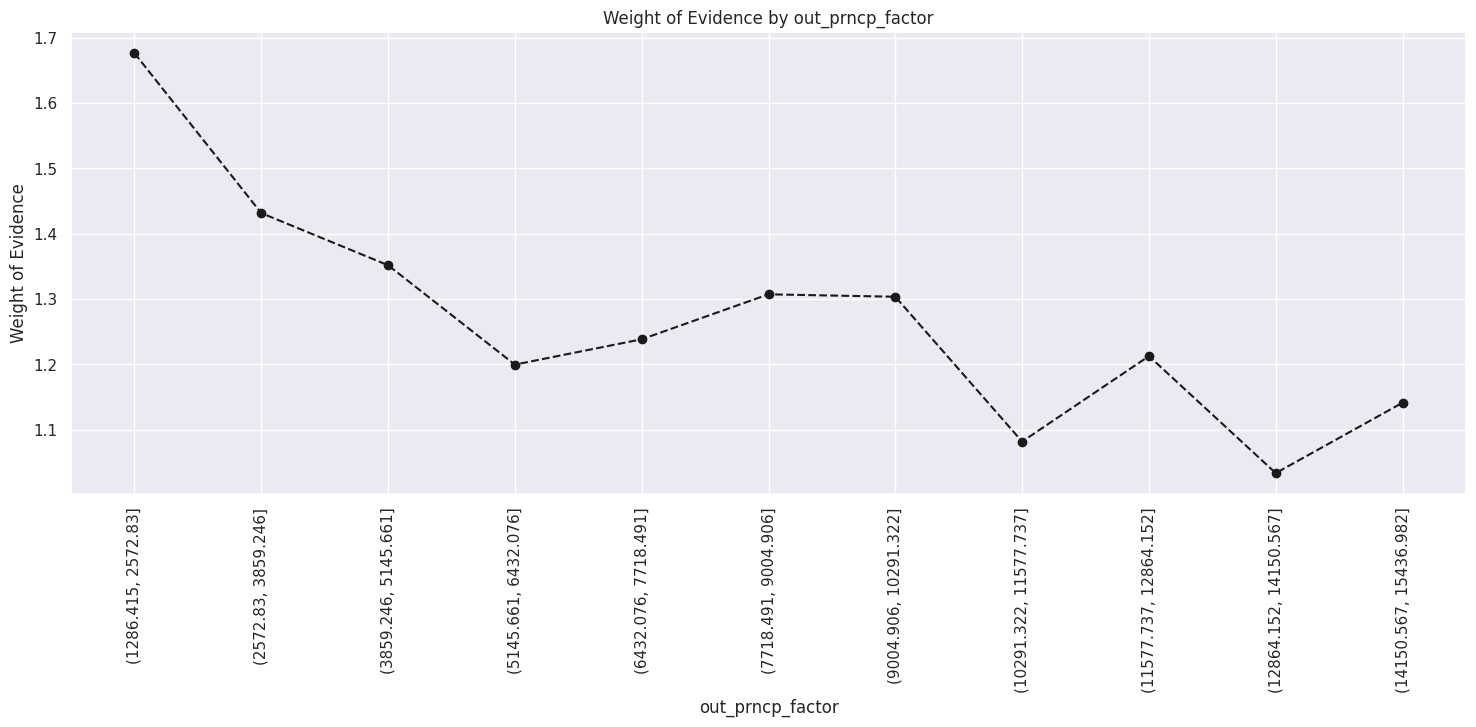

In [ ]:
plot_by_woe(df_temp.iloc[1:12,:],90)#Aquí se hizo un zoom en el area media.

In [ ]:
#"total_pymnt"
#Se percibe que hay pocos trabajos que ganen mas de 25000 lo cual es raro por eso se filtra.
X_train_prepr_temp = X_train_prepr[X_train_prepr['total_pymnt'] <= 25000].copy()


X_train_prepr_temp['total_pymnt_factor'] = pd.cut(X_train_prepr_temp['total_pymnt'], 20)

df_temp = woe_continuous(X_train_prepr_temp, 'total_pymnt_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp

,total_pymnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-25.0, 1250.0]",5609,0.473881,0.016279,2658.0,2951.0,0.008734,0.073386,-2.128553,NaN,NaN,0.548419
1,"(1250.0, 2500.0]",16242,0.685753,0.047139,11138.0,5104.0,0.036597,0.126927,-1.243645,0.211872,0.884908,0.548419
2,"(2500.0, 3750.0]",25630,0.783145,0.074386,20072.0,5558.0,0.065952,0.138217,-0.739896,0.097392,0.503749,0.548419
3,"(3750.0, 5000.0]",30880,0.833873,0.089623,25750.0,5130.0,0.084609,0.127574,-0.410654,0.050728,0.329241,0.548419
4,"(5000.0, 6250.0]",33943,0.871432,0.098513,29579.0,4364.0,0.097190,0.108525,-0.110308,0.037558,0.300347,0.548419
5,"(6250.0, 7500.0]",32268,0.891843,0.093652,28778.0,3490.0,0.094558,0.086790,0.085726,0.020412,0.196034,0.548419
6,"(7500.0, 8750.0]",28052,0.896371,0.081416,25145.0,2907.0,0.082621,0.072292,0.133554,0.004528,0.047828,0.548419
7,"(8750.0, 10000.0]",24748,0.905245,0.071826,22403.0,2345.0,0.073612,0.058316,0.232926,0.008874,0.099372,0.548419
8,"(10000.0, 11250.0]",24596,0.925760,0.071385,22770.0,1826.0,0.074817,0.045409,0.499333,0.020515,0.266407,0.548419
9,"(11250.0, 12500.0]",21711,0.936392,0.063012,20330.0,1381.0,0.066800,0.034343,0.665306,0.010631,0.165974,0.548419


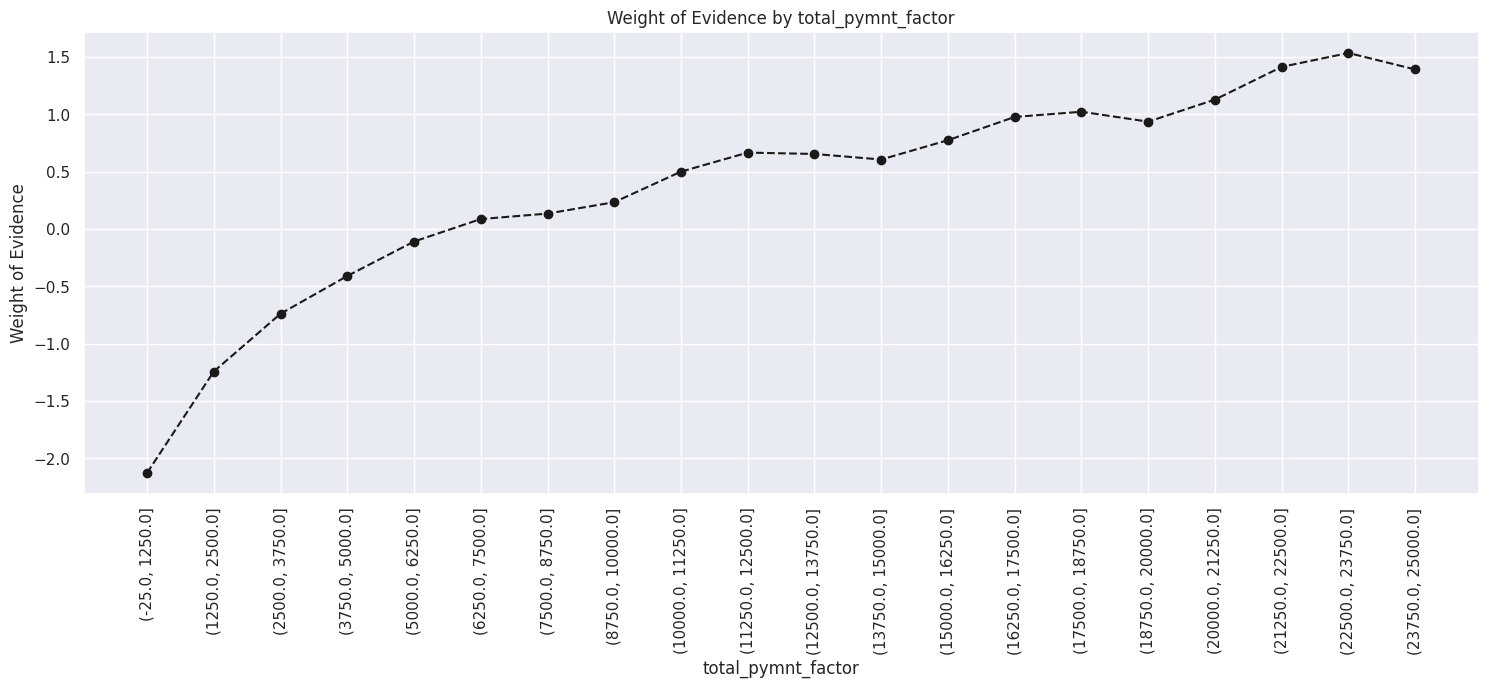

In [ ]:
plot_by_woe(df_temp,90)

In [ ]:
#total_rec_int (intereses recibidos)
# Un vistazo inicial muestra que hay muy pocas observaciones mayores a 7261, lo que debería ser muy raro, por lo que los filtraremos:
X_train_prepr_temp = X_train_prepr[X_train_prepr['total_rec_int'] <= 7261].copy()

X_train_prepr_temp['total_rec_int_factor'] = pd.cut(X_train_prepr_temp['total_rec_int'], 20)

df_temp = woe_continuous(X_train_prepr_temp, 'total_rec_int_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp


,total_rec_int_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-7.261, 363.03]",22845,0.836594,0.064964,19112.0,3733.0,0.061078,0.096345,-0.455790,NaN,NaN,0.024917
1,"(363.03, 726.061]",41058,0.872546,0.116755,35825.0,5233.0,0.114489,0.135059,-0.165233,0.035952,0.290557,0.024917
2,"(726.061, 1089.092]",45720,0.890332,0.130013,40706.0,5014.0,0.130088,0.129407,0.005247,0.017786,0.170480,0.024917
3,"(1089.092, 1452.122]",41081,0.892797,0.116821,36677.0,4404.0,0.117212,0.113663,0.030742,0.002465,0.025495,0.024917
4,"(1452.122, 1815.152]",35526,0.896977,0.101024,31866.0,3660.0,0.101837,0.094461,0.075182,0.004180,0.044440,0.024917
5,"(1815.152, 2178.183]",30227,0.898601,0.085956,27162.0,3065.0,0.086804,0.079105,0.092877,0.001624,0.017695,0.024917
6,"(2178.183, 2541.214]",25037,0.898790,0.071197,22503.0,2534.0,0.071915,0.065400,0.094955,0.000189,0.002078,0.024917
7,"(2541.214, 2904.244]",20417,0.902532,0.058059,18427.0,1990.0,0.058889,0.051360,0.136788,0.003742,0.041833,0.024917
8,"(2904.244, 3267.274]",16480,0.899636,0.046864,14826.0,1654.0,0.047381,0.042688,0.104291,0.002896,0.032497,0.024917
9,"(3267.274, 3630.305]",13114,0.897819,0.037292,11774.0,1340.0,0.037627,0.034584,0.084330,0.001817,0.019962,0.024917


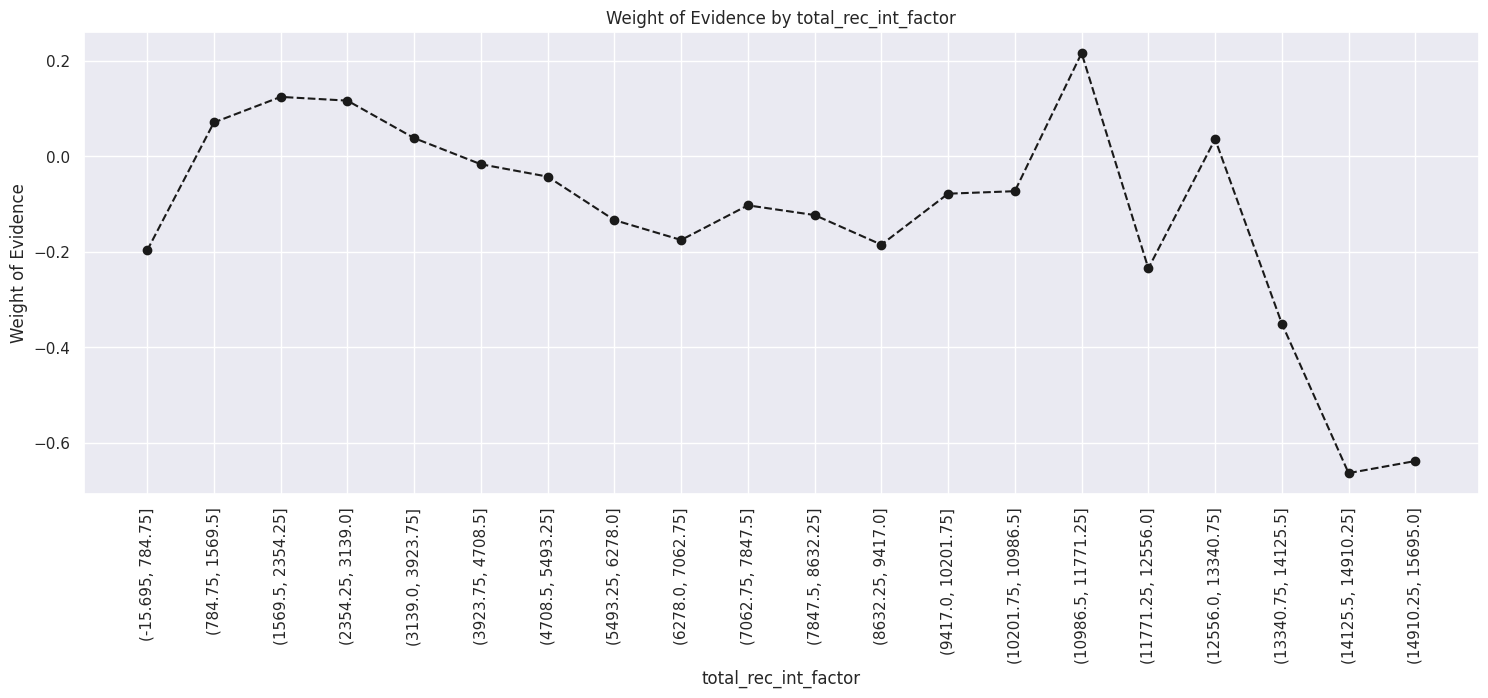

In [ ]:
plot_by_woe(df_temp, 90)#Se observan vaolores similares lo cual hace conveniente la combinación de bins:

In [ ]:
#last_pymnt_amnt(Ultimo pago total recibido).
## Una observación inicial muestra que hay muy pocas observaciones con 10,000, lo que debería ser muy raro, por lo que los filtraremos primero.
X_train_prepr_temp = X_train_prepr[X_train_prepr['last_pymnt_amnt'] <= 10000].copy()

X_train_prepr_temp['last_pymnt_amnt_factor'] = pd.cut(X_train_prepr_temp['last_pymnt_amnt'], 15)

df_temp = woe_continuous(X_train_prepr_temp, 'last_pymnt_amnt_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp
#Decartamos esta caracteristica dodo que su IV es demasiado ato y por lo tanto muy sospechoso.

#En general lo que hacemos cuando filtramos en lidiar con los oulitlers.

41058

In [ ]:
#"tot_cur_bal" (Saldo actual de todas las cuentas).
# Filtramos
X_train_prepr_temp = X_train_prepr[X_train_prepr['tot_cur_bal'] <= 64000].copy()

X_train_prepr_temp['tot_cur_bal_factor'] = pd.cut(X_train_prepr_temp['tot_cur_bal'], 25)

df_temp = woe_continuous(X_train_prepr_temp, 'tot_cur_bal_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp

#Dados los valores bajos del IV se descarta esta carácteristica.

,tot_cur_bal_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-64.0, 2560.0]",1778,0.902700,0.012373,1605.0,173.0,0.012617,0.010492,0.184381,NaN,NaN,0.00311
1,"(2560.0, 5120.0]",4621,0.897425,0.032158,4147.0,474.0,0.032600,0.028748,0.125727,0.005275,0.058654,0.00311
2,"(5120.0, 7680.0]",6453,0.897567,0.044907,5792.0,661.0,0.045531,0.040090,0.127273,0.000142,0.001546,0.00311
3,"(7680.0, 10240.0]",7500,0.887867,0.052193,6659.0,841.0,0.052347,0.051007,0.025927,0.009700,0.101346,0.00311
4,"(10240.0, 12800.0]",7949,0.883759,0.055317,7025.0,924.0,0.055224,0.056041,-0.014688,0.004108,0.040615,0.00311
5,"(12800.0, 15360.0]",8321,0.882706,0.057906,7345.0,976.0,0.057739,0.059195,-0.024894,0.001053,0.010206,0.00311
6,"(15360.0, 17920.0]",8342,0.888036,0.058052,7408.0,934.0,0.058234,0.056647,0.027633,0.005330,0.052527,0.00311
7,"(17920.0, 20480.0]",8406,0.878420,0.058498,7384.0,1022.0,0.058046,0.061984,-0.065652,0.009616,0.093285,0.00311
8,"(20480.0, 23040.0]",8246,0.880669,0.057384,7262.0,984.0,0.057087,0.059680,-0.044422,0.002249,0.021231,0.00311
9,"(23040.0, 25600.0]",8260,0.880993,0.057482,7277.0,983.0,0.057205,0.059619,-0.041342,0.000323,0.003080,0.00311


In [ ]:
#total_rev_hi_lim(Límite de crédito/crédito superior renovable total)
#Filtramos:
X_train_prepr_temp = X_train_prepr[X_train_prepr['total_rev_hi_lim'] <= 79780].copy()
# fine-classing
X_train_prepr_temp['total_rev_hi_lim_factor'] = pd.cut(X_train_prepr_temp['total_rev_hi_lim'], 25)
# preprocess
df_temp = woe_continuous(X_train_prepr_temp, 'total_rev_hi_lim_factor', y_train_prepr[X_train_prepr_temp.index])
df_temp
#Los valores IV indican poco poder de prección de la carácteristica, por el momento la dejaremos.

,total_rev_hi_lim_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-79.767, 3190.68]",3574,0.866256,0.011821,3096.0,478.0,0.011419,0.015309,-0.293149,NaN,NaN,0.022189
1,"(3190.68, 6381.36]",14632,0.880331,0.048394,12881.0,1751.0,0.047509,0.056079,-0.165838,1.407449e-02,0.127311,0.022189
2,"(6381.36, 9572.04]",24622,0.885306,0.081435,21798.0,2824.0,0.080397,0.090443,-0.117740,4.975042e-03,0.048098,0.022189
3,"(9572.04, 12762.72]",29008,0.885790,0.095941,25695.0,3313.0,0.094771,0.106104,-0.112962,4.843028e-04,0.004778,0.022189
4,"(12762.72, 15953.4]",29826,0.887481,0.098647,26470.0,3356.0,0.097629,0.107481,-0.096142,1.690595e-03,0.016820,0.022189
5,"(15953.4, 19144.08]",28069,0.888703,0.092836,24945.0,3124.0,0.092005,0.100051,-0.083845,1.222118e-03,0.012297,0.022189
6,"(19144.08, 22334.76]",25057,0.893762,0.082874,22395.0,2662.0,0.082599,0.085255,-0.031644,5.059383e-03,0.052201,0.022189
7,"(22334.76, 25525.44]",22187,0.893767,0.073381,19830.0,2357.0,0.073139,0.075487,-0.031598,4.397959e-06,0.000046,0.022189
8,"(25525.44, 28716.12]",19265,0.897898,0.063717,17298.0,1967.0,0.063800,0.062996,0.012677,4.131122e-03,0.044275,0.022189
9,"(28716.12, 31906.8]",16446,0.898760,0.054394,14781.0,1665.0,0.054517,0.053324,0.022113,8.618348e-04,0.009436,0.022189


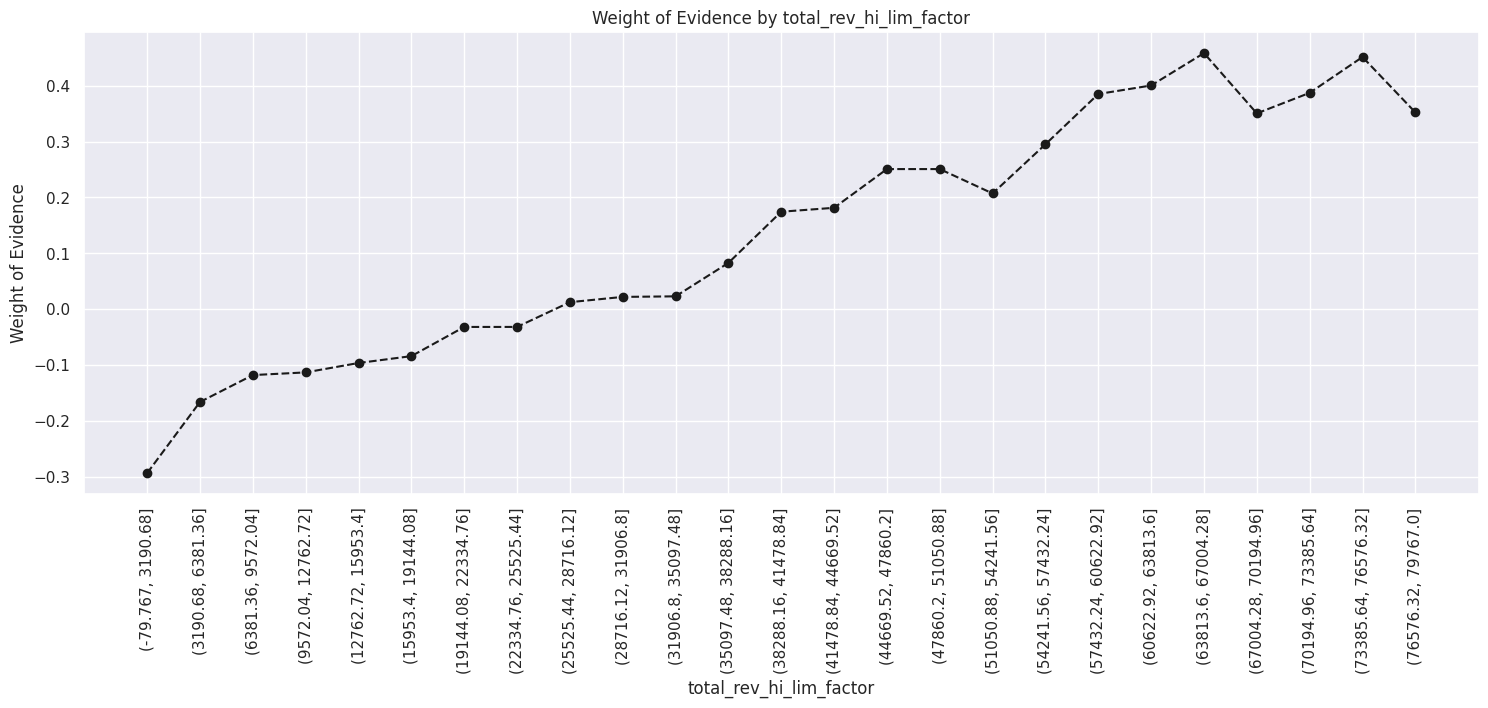

In [ ]:
plot_by_woe(df_temp, 90)

In [ ]:
#mths_since_earliest_cr_line_factor(Meses desde que se abrieron las cuentas a plazos más recientes)


X_train_prepr['mths_since_earliest_cr_line_factor'] = pd.cut(X_train_prepr['mths_since_earliest_cr_line'], 25)

df_temp = woe_continuous(X_train_prepr, 'mths_since_earliest_cr_line_factor', y_train_prepr)
df_temp

,mths_since_earliest_cr_line_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(140.486, 161.56]",2650,0.895094,0.007105,2372.0,278.0,0.007140,0.006819,0.046005,NaN,NaN,0.016102
1,"(161.56, 182.12]",6388,0.865529,0.017126,5529.0,859.0,0.016642,0.021069,-0.235869,0.029565,0.281874,0.016102
2,"(182.12, 202.68]",15672,0.862557,0.042016,13518.0,2154.0,0.040688,0.052832,-0.261167,0.002972,0.025298,0.016102
3,"(202.68, 223.24]",23403,0.873948,0.062742,20453.0,2950.0,0.061562,0.072355,-0.161538,0.011390,0.099629,0.016102
4,"(223.24, 243.8]",30963,0.882860,0.083010,27336.0,3627.0,0.082280,0.088960,-0.078064,0.008912,0.083474,0.016102
5,"(243.8, 264.36]",41418,0.886088,0.111039,36700.0,4718.0,0.110465,0.115720,-0.046471,0.003228,0.031593,0.016102
6,"(264.36, 284.92]",45873,0.884071,0.122983,40555.0,5318.0,0.122068,0.130436,-0.066301,0.002017,0.019830,0.016102
7,"(284.92, 305.48]",43012,0.888403,0.115313,38212.0,4800.0,0.115016,0.117731,-0.023329,0.004332,0.042972,0.016102
8,"(305.48, 326.04]",33146,0.891390,0.088863,29546.0,3600.0,0.088932,0.088298,0.007152,0.002986,0.030481,0.016102
9,"(326.04, 346.6]",28884,0.896794,0.077436,25903.0,2981.0,0.077967,0.073116,0.064238,0.005404,0.057085,0.016102


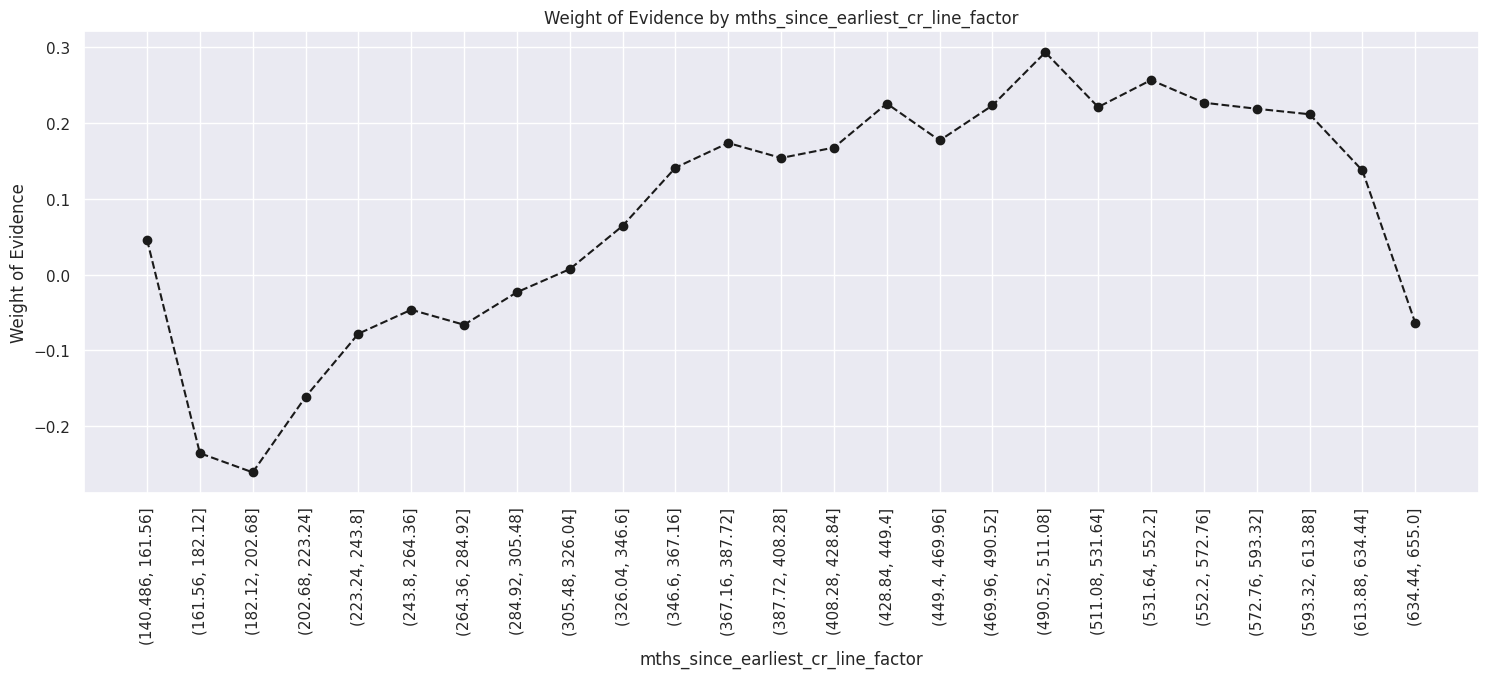

In [ ]:
plot_by_woe(df_temp, 90)

In [ ]:
#mths_since_issue_d_factor(meses desde que se financio el préstamo)
# fine-classing
X_train_prepr['mths_since_issue_d_factor'] = pd.cut(X_train_prepr['mths_since_issue_d'], 25)
# preprocess
df_temp = woe_continuous(X_train_prepr, "mths_since_issue_d_factor", y_train_prepr)
df_temp

,mths_since_issue_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(103.91, 107.6]",67865,0.934311,0.181930,63407.0,4458.0,0.190839,0.109334,0.557019,NaN,NaN,0.107728
1,"(107.6, 111.2]",67434,0.913145,0.180775,61577.0,5857.0,0.185331,0.143645,0.254796,0.021166,0.302223,0.107728
2,"(111.2, 114.8]",40680,0.900959,0.109053,36651.0,4029.0,0.110310,0.098813,0.110067,0.012186,0.144728,0.107728
3,"(114.8, 118.4]",47619,0.892837,0.127655,42516.0,5103.0,0.127962,0.125153,0.022197,0.008122,0.087871,0.107728
4,"(118.4, 122.0]",38870,0.874968,0.104201,34010.0,4860.0,0.102361,0.119194,-0.152239,0.017869,0.174436,0.107728
5,"(122.0, 125.6]",22337,0.862023,0.059880,19255.0,3082.0,0.057953,0.075587,-0.265663,0.012945,0.113424,0.107728
6,"(125.6, 129.2]",21530,0.856015,0.057717,18430.0,3100.0,0.055470,0.076029,-0.315277,0.006008,0.049614,0.107728
7,"(129.2, 132.8]",14249,0.849954,0.038198,12111.0,2138.0,0.036451,0.052435,-0.363612,0.006060,0.048334,0.107728
8,"(132.8, 136.4]",11976,0.832749,0.032105,9973.0,2003.0,0.030016,0.049124,-0.492620,0.017206,0.129008,0.107728
9,"(136.4, 140.0]",8304,0.834176,0.022261,6927.0,1377.0,0.020849,0.033772,-0.482336,0.001427,0.010284,0.107728


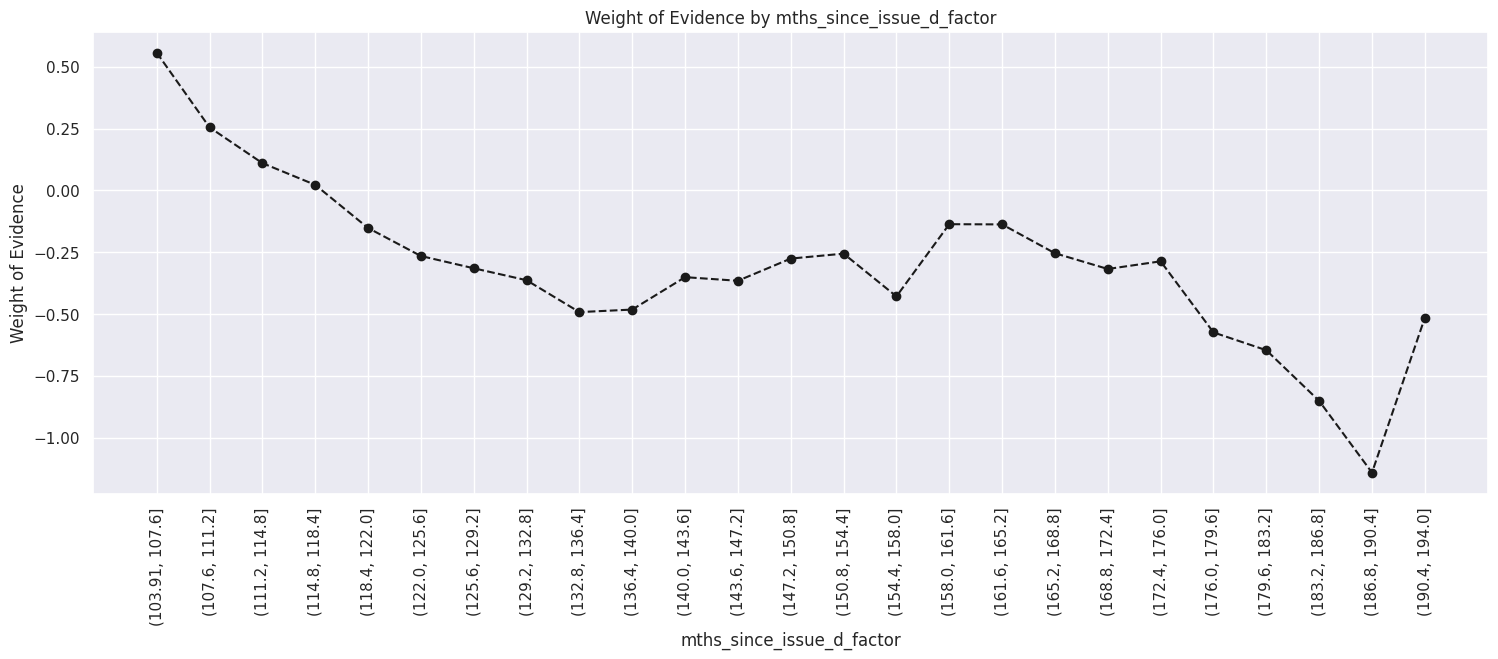

In [ ]:
plot_by_woe(df_temp, 90)

In [ ]:
#mths_since_last_pymnt_d_factor(meses desde que se recibio el ultimo pago)

X_train_prepr['mths_since_last_pymnt_d_factor'] = pd.cut(X_train_prepr['mths_since_last_pymnt_d'], 25)

df_temp = woe_continuous(X_train_prepr, "mths_since_last_pymnt_d_factor", y_train_prepr)
df_temp

,mths_since_last_pymnt_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(90.903, 94.88]",209784,0.977849,0.562851,205137.0,4647.0,0.617410,0.114846,1.681944,NaN,NaN,1.281457
1,"(94.88, 98.76]",33582,0.787922,0.090101,26460.0,7122.0,0.079638,0.176013,-0.793066,0.189927,2.475011,1.281457
2,"(98.76, 102.64]",30532,0.798637,0.081917,24384.0,6148.0,0.073390,0.151941,-0.727711,0.010715,0.065355,1.281457
3,"(102.64, 106.52]",23842,0.781394,0.063968,18630.0,5212.0,0.056072,0.128809,-0.831702,0.017243,0.103991,1.281457
4,"(106.52, 110.4]",19634,0.770908,0.052678,15136.0,4498.0,0.045556,0.111163,-0.892069,0.010487,0.060366,1.281457
5,"(110.4, 114.28]",13743,0.787164,0.036872,10818.0,2925.0,0.032559,0.072288,-0.797595,0.016257,0.094474,1.281457
6,"(114.28, 118.16]",9743,0.754080,0.026140,7347.0,2396.0,0.022113,0.059215,-0.985020,0.033085,0.187426,1.281457
7,"(118.16, 122.04]",7548,0.740991,0.020251,5593.0,1955.0,0.016834,0.048316,-1.054386,0.013089,0.069366,1.281457
8,"(122.04, 125.92]",4913,0.802565,0.013182,3943.0,970.0,0.011867,0.023973,-0.703111,0.061574,0.351275,1.281457
9,"(125.92, 129.8]",4373,0.771553,0.011733,3374.0,999.0,0.010155,0.024689,-0.888412,0.031012,0.185302,1.281457


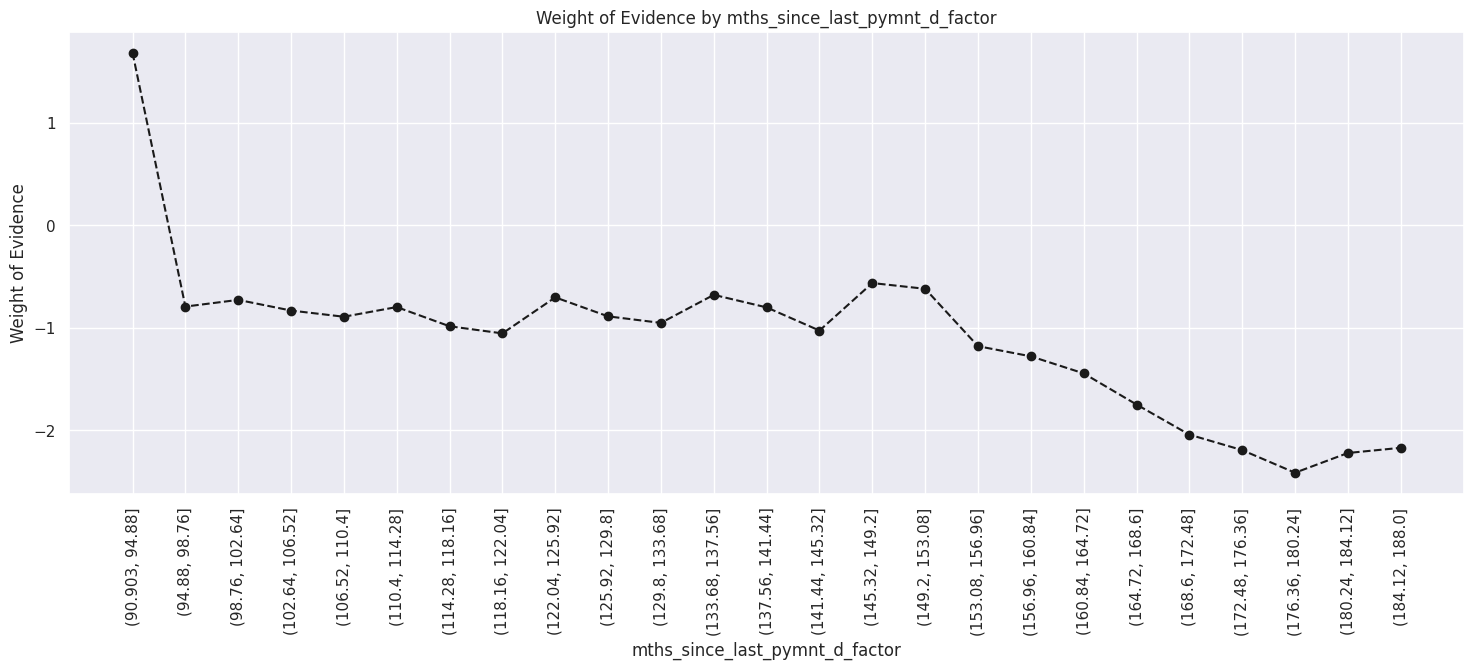

In [ ]:
plot_by_woe(df_temp, 90)#Se observan muchos valores similares

In [ ]:
#mths_since_last_credit_pull_d (El mes más reciente, LC sacó crédito para este préstamo)
#Filtramos
X_train_prepr_temp = X_train_prepr[X_train_prepr['mths_since_last_credit_pull_d'] <= 75].copy()

X_train_prepr['mths_since_last_credit_pull_d_factor'] = pd.cut(X_train_prepr['mths_since_last_credit_pull_d'], 25)

df_temp = woe_continuous(X_train_prepr, "mths_since_last_credit_pull_d_factor", y_train_prepr)
df_temp

X_train_prepr.columns

X_train_prepr[X_train_prepr['mths_since_last_credit_pull_d']]

,mths_since_last_credit_pull_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(90.896, 95.16]",292913,0.917262,0.785294,268678.0,24235.0,0.808718,0.594418,0.307868,NaN,NaN,inf
1,"(95.16, 99.32]",20402,0.842025,0.054697,17179.0,3223.0,0.051709,0.079051,-0.424472,0.075237,0.732341,inf
2,"(99.32, 103.48]",16889,0.796732,0.045279,13456.0,3433.0,0.040502,0.084202,-0.731857,0.045294,0.307385,inf
3,"(103.48, 107.64]",10574,0.768016,0.028349,8121.0,2453.0,0.024444,0.060165,-0.900706,0.028716,0.168849,inf
4,"(107.64, 111.8]",8095,0.780976,0.021703,6322.0,1773.0,0.019029,0.043487,-0.826485,0.012960,0.074221,inf
5,"(111.8, 115.96]",6467,0.736199,0.017338,4761.0,1706.0,0.014331,0.041843,-1.071541,0.044777,0.245056,inf
6,"(115.96, 120.12]",4950,0.738182,0.013271,3654.0,1296.0,0.010999,0.031787,-1.061308,0.001983,0.010234,inf
7,"(120.12, 124.28]",2937,0.773919,0.007874,2273.0,664.0,0.006842,0.016286,-0.867274,0.035737,0.194034,inf
8,"(124.28, 128.44]",2496,0.760817,0.006692,1899.0,597.0,0.005716,0.014643,-0.940682,0.013102,0.073408,inf
9,"(128.44, 132.6]",1697,0.789039,0.004550,1339.0,358.0,0.004030,0.008781,-0.778702,0.028222,0.161980,inf


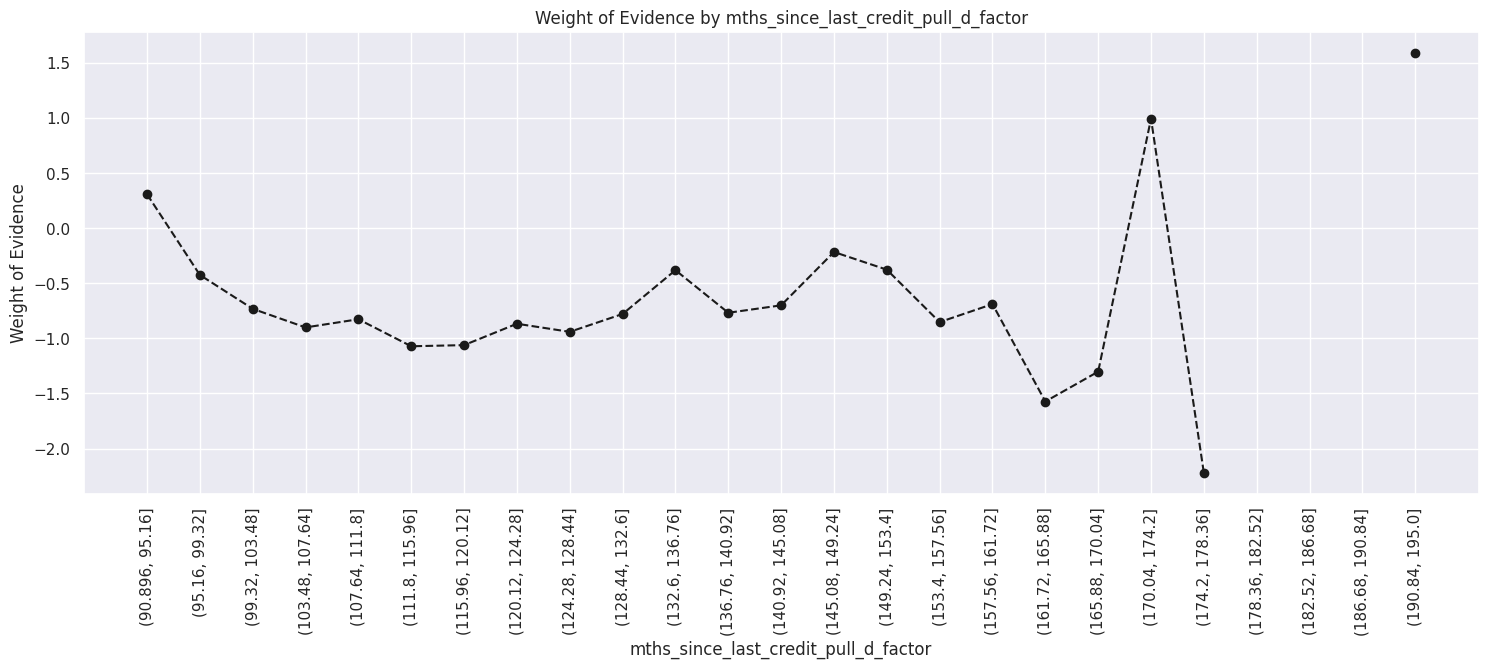

In [ ]:
plot_by_woe(df_temp, 90)

In [ ]:
#Finalizado el enalisis de las variables carácteristicas ahora tenemos una serie da caractaristicas que quitaremos o combinaremos sus bins:

#Por valores WoE muy bajas combianres bins de : grade, verification_status,term
#Por valores WoE similares combinaremos bins de : int_rate, annual_inc, dti, inq_last_6mths, revol_util, , out_prncp, total_pymnt, total_rec_int, total_rev_hi_lim, mths_since_earliest_cr_line,mths_since_issue_dmths_since_last_credit_pull_d
#Por valores IV muy bajos o muy altos eliminaremos las carácteristicas: emp_length, total_acc, last_pymnt_amnt, tot_cur_bal,mths_since_last_pymnt_d_factor

In [ ]:
#Ahora utlizaremos las clases madre BaseEstimator y TransformerMixin
##Esto nos sirve para modificar de forma estandarizada los datos de nuestro modelo y así poder usar otras herramientas.

# creamos una lista de todas las categorías de referencia, es decir, una categoría de cada una de las características globales
ref_categories = ['mths_since_last_credit_pull_d:>75', 'mths_since_issue_d:>122', 'mths_since_earliest_cr_line:>434', 'total_rev_hi_lim:>79,780',
                  'total_rec_int:>7,260', 'total_pymnt:>25,000', 'out_prncp:>15,437', 'revol_util:>1.0', 'inq_last_6mths:>4', 'dti:>35.191',
                  'annual_inc:>150K', 'int_rate:>20.281', 'term:60', 'purpose:major_purch__car__home_impr', 'verification_status:Not Verified',
                  'home_ownership:MORTGAGE', 'grade:G']

len(ref_categories)#Son las categorias que utilizaremos para modificar las variables caracteristicas.

#En la clase personalizada que crearemos a continuación, se crearan nuevas varaibles dummies categoricas basadas en los puntos de corte (filtros) que identificamos manualmente
#Con base en los diagramas y reslutados de WoE y IV.
#Todo esto para poder usar el metodo Pipeline de scikit-learn.

class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X): # sin argumentos
        self.X = X
    def fit(self, X, y = None):
        return self #nothing else to do
    def transform(self, X):
        X_new = X.loc[:, 'grade:A': 'grade:G']
        X_new['home_ownership:OWN'] = X.loc[:,'home_ownership:OWN']
        X_new['home_ownership:MORTGAGE'] = X.loc[:,'home_ownership:MORTGAGE']
        X_new['home_ownership:OTHER_NONE_RENT'] = sum([X['home_ownership:OTHER'], X['home_ownership:NONE'], X['home_ownership:RENT']])
        X_new = pd.concat([X_new, X.loc[:, 'verification_status:Not Verified':'verification_status:Verified']], axis = 1)
        # A los efectos de esta columna, mantenemos la consolidación de deuda (debido al volumen) y la tarjeta de crédito (debido a características únicas) como categorías separadas
        # Estas categorías tienen muy pocas observaciones: educativo, energía_renovable, vacaciones, casa, boda, automóvil
        # automóvil es el menos riesgoso, por lo que lo combinaremos con las otras 2 categorías menos riesgosas: home_improvement y major_purchase
        # educación, energía_renovable (ambas observaciones bajas) se combinarán con pequeñas empresas y movimiento
        # vacaciones, casa y boda (los 3 restantes con observaciones bajas) se combinarán con servicios médicos y otros
        X_new['purpose:debt_consolidation'] = X.loc[:,'purpose:debt_consolidation']
        X_new['purpose:credit_card'] = X.loc[:,'purpose:credit_card']
        X_new['purpose:major_purch__car__home_impr'] = sum([X['purpose:major_purchase'], X['purpose:car'], X['purpose:home_improvement']])
        X_new['purpose:educ__ren_en__sm_b__mov'] = sum([X['purpose:educational'], X['purpose:renewable_energy'], X['purpose:small_business'],
                                                        X['purpose:moving']])
        X_new['purpose:vacation__house__wedding__med__oth'] = sum([X['purpose:vacation'], X['purpose:house'], X['purpose:wedding'],
                                                                   X['purpose:medical'], X['purpose:other']])
        X_new['term:36'] = np.where((X['term'] == 36), 1, 0)
        X_new['term:60'] = np.where((X['term'] == 60), 1, 0)
        X_new['int_rate:<7.071'] = np.where((X['int_rate'] <= 7.071), 1, 0)
        X_new['int_rate:7.071-10.374'] = np.where((X['int_rate'] > 7.071) & (X['int_rate'] <= 10.374), 1, 0)
        X_new['int_rate:10.374-13.676'] = np.where((X['int_rate'] > 10.374) & (X['int_rate'] <= 13.676), 1, 0)
        X_new['int_rate:13.676-15.74'] = np.where((X['int_rate'] > 13.676) & (X['int_rate'] <= 15.74), 1, 0)
        X_new['int_rate:15.74-20.281'] = np.where((X['int_rate'] > 15.74) & (X['int_rate'] <= 20.281), 1, 0)
        X_new['int_rate:>20.281'] = np.where((X['int_rate'] > 20.281), 1, 0)
        X_new['annual_inc:missing'] = np.where(X['annual_inc'].isnull(), 1, 0)
        X_new['annual_inc:<28,555'] = np.where((X['annual_inc'] <= 28555), 1, 0)
        X_new['annual_inc:28,555-37,440'] = np.where((X['annual_inc'] > 28555) & (X['annual_inc'] <= 37440), 1, 0)
        X_new['annual_inc:37,440-61,137'] = np.where((X['annual_inc'] > 37440) & (X['annual_inc'] <= 61137), 1, 0)
        X_new['annual_inc:61,137-81,872'] = np.where((X['annual_inc'] > 61137) & (X['annual_inc'] <= 81872), 1, 0)
        X_new['annual_inc:81,872-102,606'] = np.where((X['annual_inc'] > 81872) & (X['annual_inc'] <= 102606), 1, 0)
        X_new['annual_inc:102,606-120,379'] = np.where((X['annual_inc'] > 102606) & (X['annual_inc'] <= 120379), 1, 0)
        X_new['annual_inc:120,379-150,000'] = np.where((X['annual_inc'] > 120379) & (X['annual_inc'] <= 150000), 1, 0)
        X_new['annual_inc:>150K'] = np.where((X['annual_inc'] > 150000), 1, 0)
        X_new['dti:<=1.6'] = np.where((X['dti'] <= 1.6), 1, 0)
        X_new['dti:1.6-5.599'] = np.where((X['dti'] > 1.6) & (X['dti'] <= 5.599), 1, 0)
        X_new['dti:5.599-10.397'] = np.where((X['dti'] > 5.599) & (X['dti'] <= 10.397), 1, 0)
        X_new['dti:10.397-15.196'] = np.where((X['dti'] > 10.397) & (X['dti'] <= 15.196), 1, 0)
        X_new['dti:15.196-19.195'] = np.where((X['dti'] > 15.196) & (X['dti'] <= 19.195), 1, 0)
        X_new['dti:19.195-24.794'] = np.where((X['dti'] > 19.195) & (X['dti'] <= 24.794), 1, 0)
        X_new['dti:24.794-35.191'] = np.where((X['dti'] > 24.794) & (X['dti'] <= 35.191), 1, 0)
        X_new['dti:>35.191'] = np.where((X['dti'] > 35.191), 1, 0)
        X_new['inq_last_6mths:missing'] = np.where(X['inq_last_6mths'].isnull(), 1, 0)
        X_new['inq_last_6mths:0'] = np.where((X['inq_last_6mths'] == 0), 1, 0)
        X_new['inq_last_6mths:1-2'] = np.where((X['inq_last_6mths'] >= 1) & (X['inq_last_6mths'] <= 2), 1, 0)
        X_new['inq_last_6mths:3-4'] = np.where((X['inq_last_6mths'] >= 3) & (X['inq_last_6mths'] <= 4), 1, 0)
        X_new['inq_last_6mths:>4'] = np.where((X['inq_last_6mths'] > 4), 1, 0)
        # Discretizaremos en los deciles para revol_util
        X_new['revol_util:missing'] = np.where(X['revol_util'].isnull(), 1, 0)
        X_new['revol_util:<0.1'] = np.where((X['revol_util'] <= 0.1), 1, 0)
        X_new['revol_util:0.1-0.2'] = np.where((X['revol_util'] > 0.1) & (X['revol_util'] <= 0.2), 1, 0)
        X_new['revol_util:0.2-0.3'] = np.where((X['revol_util'] > 0.2) & (X['revol_util'] <= 0.3), 1, 0)
        X_new['revol_util:0.3-0.4'] = np.where((X['revol_util'] > 0.3) & (X['revol_util'] <= 0.4), 1, 0)
        X_new['revol_util:0.4-0.5'] = np.where((X['revol_util'] > 0.4) & (X['revol_util'] <= 0.5), 1, 0)
        X_new['revol_util:0.5-0.6'] = np.where((X['revol_util'] > 0.5) & (X['revol_util'] <= 0.6), 1, 0)
        X_new['revol_util:0.6-0.7'] = np.where((X['revol_util'] > 0.6) & (X['revol_util'] <= 0.7), 1, 0)
        X_new['revol_util:0.7-0.8'] = np.where((X['revol_util'] > 0.7) & (X['revol_util'] <= 0.8), 1, 0)
        X_new['revol_util:0.8-0.9'] = np.where((X['revol_util'] > 0.8) & (X['revol_util'] <= 0.9), 1, 0)
        X_new['revol_util:0.9-1.0'] = np.where((X['revol_util'] > 0.9) & (X['revol_util'] <= 1.0), 1, 0)
        X_new['revol_util:>1.0'] = np.where((X['revol_util'] > 1.0), 1, 0)
        X_new['out_prncp:<1,286'] = np.where((X['out_prncp'] <= 1286), 1, 0)
        X_new['out_prncp:1,286-6,432'] = np.where((X['out_prncp'] > 1286) & (X['out_prncp'] <= 6432), 1, 0)
        X_new['out_prncp:6,432-9,005'] = np.where((X['out_prncp'] > 6432) & (X['out_prncp'] <= 9005), 1, 0)
        X_new['out_prncp:9,005-10,291'] = np.where((X['out_prncp'] > 9005) & (X['out_prncp'] <= 10291), 1, 0)
        X_new['out_prncp:10,291-15,437'] = np.where((X['out_prncp'] > 10291) & (X['out_prncp'] <= 15437), 1, 0)
        X_new['out_prncp:>15,437'] = np.where((X['out_prncp'] > 15437), 1, 0)
        X_new['total_pymnt:<10,000'] = np.where((X['total_pymnt'] <= 10000), 1, 0)
        X_new['total_pymnt:10,000-15,000'] = np.where((X['total_pymnt'] > 10000) & (X['total_pymnt'] <= 15000), 1, 0)
        X_new['total_pymnt:15,000-20,000'] = np.where((X['total_pymnt'] > 15000) & (X['total_pymnt'] <= 20000), 1, 0)
        X_new['total_pymnt:20,000-25,000'] = np.where((X['total_pymnt'] > 20000) & (X['total_pymnt'] <= 25000), 1, 0)
        X_new['total_pymnt:>25,000'] = np.where((X['total_pymnt'] > 25000), 1, 0)
        X_new['total_rec_int:<1,089'] = np.where((X['total_rec_int'] <= 1089), 1, 0)
        X_new['total_rec_int:1,089-2,541'] = np.where((X['total_rec_int'] > 1089) & (X['total_rec_int'] <= 2541), 1, 0)
        X_new['total_rec_int:2,541-4,719'] = np.where((X['total_rec_int'] > 2541) & (X['total_rec_int'] <= 4719), 1, 0)
        X_new['total_rec_int:4,719-7,260'] = np.where((X['total_rec_int'] > 4719) & (X['total_rec_int'] <= 7260), 1, 0)
        X_new['total_rec_int:>7,260'] = np.where((X['total_rec_int'] > 7260), 1, 0)
        X_new['total_rev_hi_lim:missing'] = np.where(X['total_rev_hi_lim'].isnull(), 1, 0)
        X_new['total_rev_hi_lim:<6,381'] = np.where((X['total_rev_hi_lim'] <= 6381), 1, 0)
        X_new['total_rev_hi_lim:6,381-19,144'] = np.where((X['total_rev_hi_lim'] > 6381) & (X['total_rev_hi_lim'] <= 19144), 1, 0)
        X_new['total_rev_hi_lim:19,144-25,525'] = np.where((X['total_rev_hi_lim'] > 19144) & (X['total_rev_hi_lim'] <= 25525), 1, 0)
        X_new['total_rev_hi_lim:25,525-35,097'] = np.where((X['total_rev_hi_lim'] > 25525) & (X['total_rev_hi_lim'] <= 35097), 1, 0)
        X_new['total_rev_hi_lim:35,097-54,241'] = np.where((X['total_rev_hi_lim'] > 35097) & (X['total_rev_hi_lim'] <= 54241), 1, 0)
        X_new['total_rev_hi_lim:54,241-79,780'] = np.where((X['total_rev_hi_lim'] > 54241) & (X['total_rev_hi_lim'] <= 79780), 1, 0)
        X_new['total_rev_hi_lim:>79,780'] = np.where((X['total_rev_hi_lim'] > 79780), 1, 0)
        X_new['mths_since_earliest_cr_line:missing'] = np.where(X['mths_since_earliest_cr_line'].isnull(), 1, 0)
        X_new['mths_since_earliest_cr_line:<125'] = np.where((X['mths_since_earliest_cr_line'] <= 125), 1, 0)
        X_new['mths_since_earliest_cr_line:125-167'] = np.where((X['mths_since_earliest_cr_line'] > 125) & (X['mths_since_earliest_cr_line'] <= 167), 1, 0)
        X_new['mths_since_earliest_cr_line:167-249'] = np.where((X['mths_since_earliest_cr_line'] > 167) & (X['mths_since_earliest_cr_line'] <= 249), 1, 0)
        X_new['mths_since_earliest_cr_line:249-331'] = np.where((X['mths_since_earliest_cr_line'] > 249) & (X['mths_since_earliest_cr_line'] <= 331), 1, 0)
        X_new['mths_since_earliest_cr_line:331-434'] = np.where((X['mths_since_earliest_cr_line'] > 331) & (X['mths_since_earliest_cr_line'] <= 434), 1, 0)
        X_new['mths_since_earliest_cr_line:>434'] = np.where((X['mths_since_earliest_cr_line'] > 434), 1, 0)
        X_new['mths_since_issue_d:<79'] = np.where((X['mths_since_issue_d'] <= 79), 1, 0)
        X_new['mths_since_issue_d:79-89'] = np.where((X['mths_since_issue_d'] > 79) & (X['mths_since_issue_d'] <= 89), 1, 0)
        X_new['mths_since_issue_d:89-100'] = np.where((X['mths_since_issue_d'] > 89) & (X['mths_since_issue_d'] <= 100), 1, 0)
        X_new['mths_since_issue_d:100-122'] = np.where((X['mths_since_issue_d'] > 100) & (X['mths_since_issue_d'] <= 122), 1, 0)
        X_new['mths_since_issue_d:>122'] = np.where((X['mths_since_issue_d'] > 122), 1, 0)
        X_new['mths_since_last_credit_pull_d:missing'] = np.where(X['mths_since_last_credit_pull_d'].isnull(), 1, 0)
        X_new['mths_since_last_credit_pull_d:<56'] = np.where((X['mths_since_last_credit_pull_d'] <= 56), 1, 0)
        X_new['mths_since_last_credit_pull_d:56-61'] = np.where((X['mths_since_last_credit_pull_d'] > 56) & (X['mths_since_last_credit_pull_d'] <= 61), 1, 0)
        X_new['mths_since_last_credit_pull_d:61-75'] = np.where((X['mths_since_last_credit_pull_d'] > 61) & (X['mths_since_last_credit_pull_d'] <= 75), 1, 0)
        X_new['mths_since_last_credit_pull_d:>75'] = np.where((X['mths_since_last_credit_pull_d'] > 75), 1, 0)
        X_new.drop(columns = ref_categories, inplace = True)#Eliminamos las categorias originales
        return X_new

#Esto que hemos hecho nos permitira hacer un seguimiento adecuado de las categorías, si es necesario.



---



---

# Modelo Regresion logistica

In [ ]:
# Revisamos la forma de nuestros conjuntos de datos
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(373028, 51)
(373028,)
(93257, 51)
(93257,)


In [ ]:
#Ahora utilizaremos la clase pipeline que sirve para integrar en un solo objeto el preprocesamiento de los datos (serie de transformaciones y ajustes en los datos brutos antes de utilizarlos para entrenar un modelo o realizar análisis).
## Y el modelo de clasificación que utilizaremos.
##Esto hace que sea más entendible el modelo y simplifica su evaluación.
###Además, el pipeline asegura que las transformaciones se apliquen de manera consistente tanto en los datos de entrenamiento como en los de prueba.
###Los pipelines son esenciales para garantizar que no haya fugas de datos y para realizar una validación cruzada adecuada en todo el flujo de trabajo de aprendizaje automático.
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')#El modelo, determinaremos el parametro "class_weigth"
#Esto obligará al modelo de regresión logística a aprender los coeficientes del modelo mediante el aprendizaje sensible a los costos, es decir, penalizar los falsos negativos más que los falsos positivos durante el entrenamiento del modelo.
#El aprendizaje sensible a los costos es útil para conjuntos de datos desequilibrados, que suele ser el caso en la calificación crediticia.

woe_transform = WoE_Binning(X)#Es es la clase personalizada que definimos previamente.

pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])

#Ahora para definir los criterios de la validación cruzada
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)#Aqui definimos un tipo de validación cruzada (con particionamito estratificado).
#La validación cruzada se utiliza para evaluar el rendimiento de un modelo y estimar cómo se generalizará a datos no vistos.
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
#El resultado que tenemos aqui es una matriz con las puntuaciones que obtuvo cada fold(partición) en total son 15 por las 3 repeticiones.
#Los folds se utilizan para simular el comportamiento del modelo con unos datos dados.

#Utilizaremos la metrica AUROC para evaluar las calificaciones obtenidas en la validación cruzada
#el AUC-ROC es una métrica que evalúa la capacidad de un modelo de clasificación binaria para distinguir entre las dos clases.
AUROC = np.mean(scores)
#Tambien se utiliza la metrica GINI para e
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))#Cuanto más alta la cifra mejor desempeño tiene nuestro modelo.
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.8625
Gini: 0.7249


In [ ]:
scores

array([0.86174468, 0.86047273, 0.85929029, 0.86549214, 0.86517362,
       0.85890691, 0.86241736, 0.86325441, 0.86299771, 0.864743  ,
       0.86397561, 0.85872355, 0.86425332, 0.86109379, 0.86421145])

In [ ]:
#Ahora si entrenemos el modelo, utilando la clase personalizada que creamos
pipeline.fit(X_train, y_train)

Pipeline(steps=[('woe',
                 WoE_Binning(X=        loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0            5000         5000           4975.0   36 months     10.65   
1            2500         2500           2500.0   60 months     15.27   
2            2400         2400           2400.0   36 months     15.96   
3           10000        10000          10000.0   36 months     13.49   
4            3000         3000           3000.0   60 months     12.69   
...           ...          ...              ...         ...       ...   
466280      18400        18400          18400.0   60 months     14.47   
466281      22000        22000          22000.0   60 months     19.97   
466282      20700        20700          20700.0   60 months     1...
        acc_now_delinq tot_coll_amt  tot_cur_bal  total_rev_hi_lim  
0                  0.0          NaN          NaN               NaN  
1                  0.0          NaN          NaN               NaN  
2                  0.0          NaN          NaN               NaN  
3                  0.0          NaN          NaN               NaN  
4                  0.0          NaN          NaN               NaN  
...                ...          ...          ...               ...  
466280             0.0          0.0     294998.0           29900.0  
466281             0.0          0.0     221830.0           39400.0  
466282             0.0          0.0      73598.0           13100.0  
466283             0.0          0.0     591610.0           53100.0  
466284             0.0          0.0      57477.0           16000.0  

[466285 rows x 42 columns])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [ ]:
#Creemos un dataframe con los coeficientes de la regresion:
X_train_woe_transformed = woe_transform.fit_transform(X_train)
feature_name = X_train_woe_transformed.columns.values#extraemos y almacenas los nombres cde las columnas como una lista


#Ccreamos el dataframe, modificamos los indices para agruegar el intercepto y ordenamos los resultados.
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
summary_table.sort_index(inplace = True)
summary_table

,Feature name,Coefficients
0,Intercept,3.312345
1,grade:A,0.846895
2,grade:B,0.659360
3,grade:C,0.510452
4,grade:D,0.418459
...,...,...
80,mths_since_issue_d:100-122,0.072304
81,mths_since_last_credit_pull_d:missing,0.179794
82,mths_since_last_credit_pull_d:<56,0.000000
83,mths_since_last_credit_pull_d:56-61,0.000000


# Predicción:

In [ ]:
#Ya que entrenamos el modelo ahora sigue realizar las predicciones:
y_hat_test = pipeline.predict(X_test)
#Obtenemos las probabilidade de nuestras predicciones
y_hat_test_proba = pipeline.predict_proba(X_test)#Nos da la probabiidad para cada muestra (elemento) de pertenecer a cada una de las clases(buenos o malos prestamos).
#Guardamos solo las probabilidades de de pertenecer a la clase 1 (buenos prestamos):
y_hat_test_proba = y_hat_test_proba[:][: , 1]


In [ ]:
#Vamos a crear un df con las clases verdaderes y las probabilidades predichas

#Creamos un conjunto de prueba temporal y reseteamos sus indices para hacer una concatenacion correcta:
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)#Concatenamos

#Verificamos la forma
y_test_proba.shape

#Renombramos las columnas
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
y_test_proba.head(10)


#Homogeneisamos los indices
y_test_proba.index = X_test.index


In [ ]:
#Matriz de confucion: Esta matriz nos ayuda a evaluar la precision de las predicciones hechas por el modelo.
##Osea evaluar el rendimineto del modelo, sobre todo cuando las clases estan desequilibradas

#Asignamos un valor que sera nuestro umbral para asignar la clase predicha.

um = 0.5

#Ahora creamos una nueva columna que tendra la clase predicha con base a la probabilidad y al umbral:
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > um, 1, 0)

#La matiz de confución:
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')
#Nos da el porcentaje de cada prediccion bien hecha o mal hecha segun las 2 clases(positiva y negativa ó 1 y 0)
#Siendo la diagola principal que tanta precisión tuvo el modelo.

array([[0.08865822, 0.02065261],
       [0.19061304, 0.70007613]])

array([1.99958079, 0.99958079, 0.99630834, ..., 0.02558227, 0.02557164,
       0.00388115])

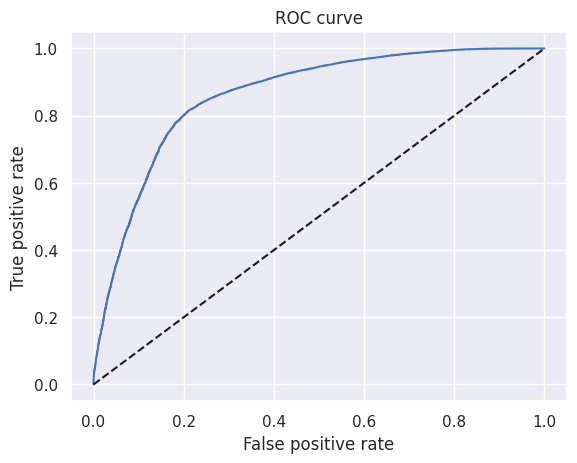

In [ ]:
#Curva ROC , esta curva grafica la relación entre la tasa de verdaderos positivos(TPR) y la tasa de falsos positivos.
## Y así podemos evaluar el rendiminto del modelo de clasificación binaria.

fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])

#Graficamos:
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

#La forma que muestra la curva indica un buen desempeño de nuestro modelo.
thresholds
#La curva se evalua para todos los umbrales de decisión (thresholds) entre 0 y 1.
#Esto se hace para tener una metrica confiable, dado que el umbral de decisión afecta como se asignan las etiquetas (clasificación)
#El thresholds

In [ ]:
len(thresholds)#Se usaron 17,037 umbrales de desición.


17037

In [ ]:
#Evaluando con diiferentes metricas el desempeño:
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
AUROC
Gini = AUROC * 2 - 1
Gini


#Los inputs para la metrica auc
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
#Esta metrica nos brinda información sobre la capacidad de discriminar por parte del modelo en clasificación binaria.
##Es útil cuando las clases estan desequilibradas.
auc_pr = auc(recall, precision)
auc_pr


0.9756666710983497

In [ ]:
#Aplicación del modelo y creacion del scorecard:

#Creamos un data frame con las caracteristicas que excluimos en el entrenamiento, obviamente su coeficiente sera cero.
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
df_ref_categories['Coefficients'] = 0
df_ref_categories

,Feature name,Coefficients
0,mths_since_last_credit_pull_d:>75,0
1,mths_since_issue_d:>122,0
2,mths_since_earliest_cr_line:>434,0
3,"total_rev_hi_lim:>79,780",0
4,"total_rec_int:>7,260",0
5,"total_pymnt:>25,000",0
6,"out_prncp:>15,437",0
7,revol_util:>1.0,0
8,inq_last_6mths:>4,0
9,dti:>35.191,0


In [ ]:
#Combinamos los dataframe resutados del modelo y el que acabamos de hacer:
df_scorecard = pd.concat([summary_table, df_ref_categories])
# reseteamos los indices
df_scorecard.reset_index(inplace = True)
df_scorecard

,index,Feature name,Coefficients
0,0,Intercept,3.312345
1,1,grade:A,0.846895
2,2,grade:B,0.659360
3,3,grade:C,0.510452
4,4,grade:D,0.418459
...,...,...,...
97,12,term:60,0.000000
98,13,purpose:major_purch__car__home_impr,0.000000
99,14,verification_status:Not Verified,0.000000
100,15,home_ownership:MORTGAGE,0.000000


In [ ]:
#Creamos una nueva columna con los nombres de las carácteristicas originales
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard


,index,Feature name,Coefficients,Original feature name
0,0,Intercept,3.312345,Intercept
1,1,grade:A,0.846895,grade
2,2,grade:B,0.659360,grade
3,3,grade:C,0.510452,grade
4,4,grade:D,0.418459,grade
...,...,...,...,...
97,12,term:60,0.000000,term
98,13,purpose:major_purch__car__home_impr,0.000000,purpose
99,14,verification_status:Not Verified,0.000000,verification_status
100,15,home_ownership:MORTGAGE,0.000000,home_ownership


In [ ]:
#Ahora con base a las convenciones que existen en la materia determinaremos los maximos y minimos valores que tomara nuestra scorecard:
min_score = 300
max_score = 850


#Calculamos la suma de los coeficientes minimos y maximos de cada categoria(para cada variabla caracteristica) dentro del nombre de la caracteristica original
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()

#Calculamos la puntuación
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)

#Actulizamos el puntaje para el intercepto es decir el puntaje promedio:
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score


#Redondeamos los resultados en una nueva columna:
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard


,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary
0,0,Intercept,3.312345,Intercept,612.309888,612.0
1,1,grade:A,0.846895,grade,22.601529,23.0
2,2,grade:B,0.659360,grade,17.596692,18.0
3,3,grade:C,0.510452,grade,13.622707,14.0
4,4,grade:D,0.418459,grade,11.167641,11.0
...,...,...,...,...,...,...
97,12,term:60,0.000000,term,0.000000,0.0
98,13,purpose:major_purch__car__home_impr,0.000000,purpose,0.000000,0.0
99,14,verification_status:Not Verified,0.000000,verification_status,0.000000,0.0
100,15,home_ownership:MORTGAGE,0.000000,home_ownership,0.000000,0.0


In [ ]:
#Revisamos que las claificaciones esten en el rango establecido
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel,max_sum_score_prel)


300.0 849.0


In [ ]:
df_scorecard['Score  - Final'] = df_scorecard['Score - Preliminary']
df_scorecard

#Este score-card (tabla de mando) final, en terminos simples son valores la importancia de dada categoria por caracteristica
##Para determinar que ten buen pagador es un individuo.
###Al final dadp que tenemo variables categoricas dummy, el individuo partira con la calificacion promedio(intercepto)
###Y se le sumara puntaje conforme sea su variabe categorica.


,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Score - Final
0,0,Intercept,3.312345,Intercept,612.309888,612.0,612.0
1,1,grade:A,0.846895,grade,22.601529,23.0,23.0
2,2,grade:B,0.659360,grade,17.596692,18.0,18.0
3,3,grade:C,0.510452,grade,13.622707,14.0,14.0
4,4,grade:D,0.418459,grade,11.167641,11.0,11.0
...,...,...,...,...,...,...,...
97,12,term:60,0.000000,term,0.000000,0.0,0.0
98,13,purpose:major_purch__car__home_impr,0.000000,purpose,0.000000,0.0,0.0
99,14,verification_status:Not Verified,0.000000,verification_status,0.000000,0.0,0.0
100,15,home_ownership:MORTGAGE,0.000000,home_ownership,0.000000,0.0,0.0


In [ ]:
# Calculo de las calificaciones crediticias para todas las observaciones del conjunto de prueba:

#Creamos un conjunto de prueba transformado, con nuestra clase personalizada:

X_test_woe_transformed = woe_transform.fit_transform(X_test)

#Insertamos una columna intercepto para alinearala con el numero de filas del score-card
#Ya que se hara una multiplicacion mantricial.
X_test_woe_transformed.insert(0, 'Intercept', 1)
X_test_woe_transformed.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:OTHER_NONE_RENT,verification_status:Source Verified,...,mths_since_earliest_cr_line:249-331,mths_since_earliest_cr_line:331-434,mths_since_issue_d:<79,mths_since_issue_d:79-89,mths_since_issue_d:89-100,mths_since_issue_d:100-122,mths_since_last_credit_pull_d:missing,mths_since_last_credit_pull_d:<56,mths_since_last_credit_pull_d:56-61,mths_since_last_credit_pull_d:61-75
395346,1,0,0,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,0,0,0
376583,1,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
297790,1,0,0,1,0,0,0,0,1,1,...,1,0,0,0,0,1,0,0,0,0
47347,1,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
446772,1,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0


In [ ]:
#Guardamos una lista con nuestras scores finales:
scorecard_scores = df_scorecard['Score - Preliminary']

#Revisamos la forma de nuestra dataframe y lista
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

#Se observa que el dataframe de prueba tiene 17 columnas menos que renglones en la lista del score.
#Por lo que procedemos a agregar las categorias referencias que se puntuan con 0 y no afectan.
X_test_woe_transformed = pd.concat([X_test_woe_transformed, pd.DataFrame(dict.fromkeys(ref_categories, [0] * len(X_test_woe_transformed)),
                                                                         index = X_test_woe_transformed.index)], axis = 1)

#Necesitamos convertir en matriz la lista para hacer la multiplicacion por punto de matrices

scorecard_scores = scorecard_scores.values.reshape(102, 1)
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(93257, 85)
(102,)
(93257, 102)
(102, 1)


In [ ]:
#Ahora podemos hacer la multiplicacion y obtener la calificación crediticia de cada individio:
y_scores = X_test_woe_transformed.dot(scorecard_scores)
y_scores.head(20)
y_scores.columns = ["Calificación crediticia"]
y_scores

,Calificación crediticia
395346,503.0
376583,582.0
297790,536.0
47347,565.0
446772,471.0
...,...
32147,551.0
78936,574.0
459582,503.0
454915,560.0


In [ ]:
#Ahora establezcamos los limites de aprovación para los préstamos:

#La tarea aqui encontrar una forma adecuada para determinar que prestamos se aprueban ó se rechazan?:
#Para ayudarnos en esta tarea recurrimos a la curva ROC, dado que traza el FPR(False positve rate) y el TPR(True positive rate).
##Nuestro objetivo sera encontrar el umbral que minimiza el FPR y maximiza el TPR.
###Osea el umbrar que mejor clasifica.



#Para esto usamos el estadistico J de Youlen(calculado en los terminos que necesitamos):
#Es una métrica que busca encontrar un umbral de decisión óptimo para el modelo.
#El estadístico J de Youden es útil cuando deseas encontrar un umbral de decisión que maximice tanto la sensibilidad como la especificidad simultáneamente, lo que es especialmente relevante cuando las consecuencias de los falsos positivos y falsos negativos son diferentes y deseas encontrar un punto de equilibrio entre ambas tasas para obtener un rendimiento óptimo del modelo de clasificación binaria.

# Calculate Youden's J-Statistic to identify the best threshhold
J = tpr - fpr

#Localizamos el indice que  J más grande:
ix = np.argmax(J)

best_thresh = thresholds[ix]#ubicamos el umbral relacionado con el estadistico J

print('Best Threshold: %f' % (best_thresh))
#Dado el umbral se aprovaran prestamos con con probabilidades mayores a este, y viceversa.


Best Threshold: 0.441304


In [ ]:
# Actualizamos el umbral y observamos si hay mejora en el modelo con la matriz de confusión.
tr = best_thresh
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# Matriz de confusión
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

#No se observan cambios significativos.


array([[0.08629915, 0.02301168],
       [0.16494204, 0.72574713]])

In [ ]:
#Ahora calcularemos las tases de aceptación y rechazo dado el umbral calculado.

#Creamos un dataframe con los umbrales y su respectiva calificación:


df_cutoffs = pd.DataFrame(thresholds, columns = ['thresholds'])

#Calculo del Score crediticio relacionado al umbral:
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) *
                       ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()
df_cutoffs.head()


,thresholds,Score
0,1.999581,NaN
1,0.999581,731.0
2,0.996308,673.0
3,0.996305,673.0
4,0.995529,668.0


In [ ]:
#Crearemos una funcion para asignar valores de 0 y 1, deacuerdo a si se aprueba o rechaza el prestamo y respecto las probabilidades y un umbral de desición.
##Y luego sumaremos para ver cuantos se aprovaron
def n_approved(p):
    return np.where(y_test_proba['y_hat_test_proba'] >= p, 1, 0).sum()

#Se calcula el numero de prestamos aprobados deacuerdo a todos los umbrales de desición:
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)

# Tambien podemos calcular el numero de prestamos rechazados:
df_cutoffs['N Rejected'] = y_test_proba['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']

#Calculamos las tasas de aprovación y rechazo de solicitudes de prestamos:
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / y_test_proba['y_hat_test_proba'].shape[0]
# Rejection rate equals one minus approval rate.
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']

#Así queda el df:

df_cutoffs.tail()

#Revisimos estas tasas para nuestro umbral calculado:
df_cutoffs[df_cutoffs['thresholds'].between( 0.441304, 0.445304)]


,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
7729,0.445297,518.0,69650,23607,0.746861,0.253139
7730,0.445274,518.0,69651,23606,0.746872,0.253128
7731,0.445272,518.0,69652,23605,0.746882,0.253118
7732,0.445265,518.0,69653,23604,0.746893,0.253107
7733,0.445005,518.0,69661,23596,0.746979,0.253021
7734,0.444921,518.0,69662,23595,0.746990,0.253010
7735,0.444784,518.0,69670,23587,0.747075,0.252925
7736,0.444742,518.0,69672,23585,0.747097,0.252903
7737,0.444183,518.0,69694,23563,0.747333,0.252667
7738,0.444179,518.0,69695,23562,0.747343,0.252657


In [ ]:
#Comparada con un umbral por estandar
df_cutoffs[df_cutoffs['thresholds'].between(0.5, 0.5001)]

#Este umbral tiene una tasa de rechazo muy alta y se podria traducir en perdidas.

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
7240,0.500071,524.0,67210,26047,0.720697,0.279303
7241,0.500063,524.0,67211,26046,0.720707,0.279293


El scorecrediticio relaciondo a este umbral es 524, implicita mente las solicitudes menores a esta calificación seran rechazadas.